<a href="https://colab.research.google.com/github/kmt112/themarketanalyst/blob/master/HousingPrices_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm,skew
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn import preprocessing
import io

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [4]:
from google.colab import files
uploaded = files.upload()

Saving Train.csv to Train.csv


In [5]:
df = pd.read_csv(io.StringIO(uploaded['Train.csv'].decode('cp1252')))
#df = pd.read_csv(io.BytesIO(data_to_load['Train.csv'])) #have not tried if this works

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,floortype,floor_no
0,https://bj.lianjia.com/chengjiao/101084782030....,1.01e+11,116.475489,40.019520,1.110000e+12,09-08-16,1464.0,106,415.0,31680,131.00,2,1,1,1,¸ß 26,1,2005,3,6,0.217,1,0,1,7,56021,¸ß,26
1,https://bj.lianjia.com/chengjiao/101086012217....,1.01e+11,116.453917,39.881534,1.110000e+12,28-07-16,903.0,126,575.0,43436,132.38,2,2,1,2,¸ß 22,1,2004,4,6,0.667,1,1,0,7,71539,¸ß,22
2,https://bj.lianjia.com/chengjiao/101086041636....,1.01e+11,116.561978,39.877145,1.110000e+12,11-12-16,1271.0,48,1030.0,52021,198.00,3,2,1,3,ÖÐ 4,4,2005,3,6,0.500,1,0,0,7,48160,ÖÐ,4
3,https://bj.lianjia.com/chengjiao/101086406841....,1.01e+11,116.438010,40.076114,1.110000e+12,30-09-16,965.0,138,297.5,22202,134.00,3,1,1,1,µ× 21,1,2008,1,6,0.273,1,0,0,6,51238,µ×,21
4,https://bj.lianjia.com/chengjiao/101086920653....,1.01e+11,116.428392,39.886229,1.110000e+12,28-08-16,927.0,286,392.0,48396,81.00,2,1,1,1,ÖÐ 6,4,1960,2,2,0.333,0,1,1,1,62588,ÖÐ,6


In [7]:
total = df.isnull().sum().sort_values(ascending=False)
percent= (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
DOM,145432,0.488524
floor_no,0,0.000000
floortype,0,0.000000
id,0,0.000000
Lng,0,0.000000
Lat,0,0.000000
Cid,0,0.000000
tradeTime,0,0.000000
followers,0,0.000000
totalPrice,0,0.000000


By the looks of this it seems that there are alot of null entries for DOM. It seems like we can adjust for the rest

In [8]:
df = df.drop(['Cid','id','url','DOM','tradeTime'],axis='columns')

In [9]:
df.head()

,Lng,Lat,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,floortype,floor_no
0,116.475489,40.019520,106,415.0,31680,131.00,2,1,1,1,¸ß 26,1,2005,3,6,0.217,1,0,1,7,56021,¸ß,26
1,116.453917,39.881534,126,575.0,43436,132.38,2,2,1,2,¸ß 22,1,2004,4,6,0.667,1,1,0,7,71539,¸ß,22
2,116.561978,39.877145,48,1030.0,52021,198.00,3,2,1,3,ÖÐ 4,4,2005,3,6,0.500,1,0,0,7,48160,ÖÐ,4
3,116.438010,40.076114,138,297.5,22202,134.00,3,1,1,1,µ× 21,1,2008,1,6,0.273,1,0,0,6,51238,µ×,21
4,116.428392,39.886229,286,392.0,48396,81.00,2,1,1,1,ÖÐ 6,4,1960,2,2,0.333,0,1,1,1,62588,ÖÐ,6



 mu= 349.24

 
 mu=5.70 and sigma = 0.58



Text(0.5, 0.98, 'After Transformation')

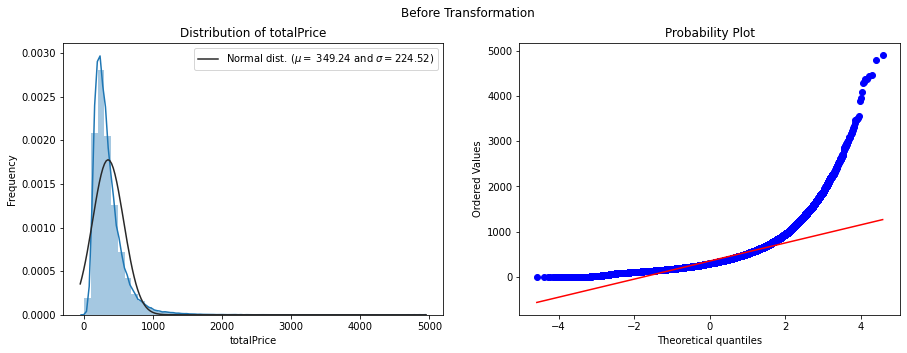

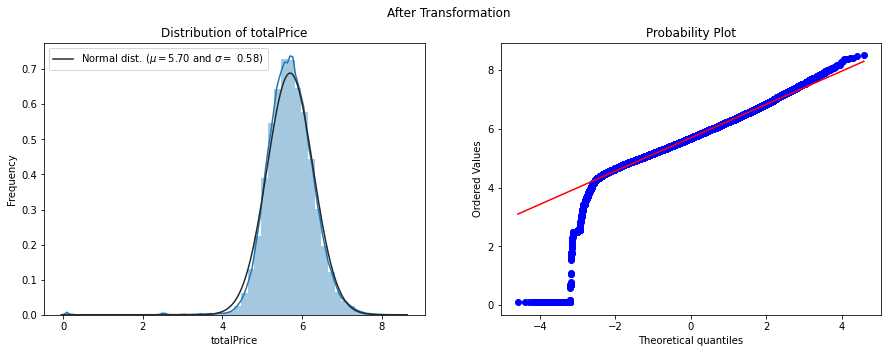

In [10]:
fig =plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['totalPrice'], fit=norm);
(mu,sigma)= norm.fit(df['totalPrice'])
print('\n mu= {:.2f}\n'.format(mu,sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=${:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('Distribution of totalPrice')
plt.subplot(1,2,2)
res=stats.probplot(df['totalPrice'],plot=plt)
plt.suptitle('Before Transformation')

df.totalPrice=np.log1p(df.totalPrice)
y=df.totalPrice.values
y_orig=df.totalPrice

fig=plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df['totalPrice'], fit=norm);
(mu,sigma)=norm.fit(df['totalPrice'])
print(' \n mu={:.2f} and sigma = {:.2f}\n'.format(mu,sigma))
plt.legend(['Normal dist. ($\mu=${:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Distribution of totalPrice')
plt.subplot(1,2,2)
res=stats.probplot(df['totalPrice'], plot=plt)
plt.suptitle('After Transformation')


In [11]:
df.describe()

,Lng,Lat,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,floor_no
count,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000,297697.000000
mean,116.418607,39.949769,17.169787,5.696900,43820.566640,82.681475,2.011223,1.171366,0.994639,1.182494,3.028956,1999.197835,2.616335,4.421324,0.381867,0.570708,0.651511,0.602025,6.751660,63689.042721,13.166250
std,0.111230,0.091512,34.740435,0.579099,21789.696788,35.730321,0.764838,0.512372,0.102725,0.422909,1.265525,8.763087,1.307001,1.907766,0.175916,0.494976,0.476492,0.489481,2.813764,22167.682746,7.761781
min,116.072514,39.627030,0.000000,0.095310,1.000000,7.370000,0.000000,0.000000,0.000000,0.000000,1.000000,1950.000000,1.000000,1.000000,0.014000,0.000000,0.000000,0.000000,1.000000,10847.000000,1.000000
25%,116.345810,39.893200,0.000000,5.327876,28224.000000,57.930000,1.000000,1.000000,1.000000,1.000000,1.000000,1994.000000,1.000000,2.000000,0.250000,0.000000,0.000000,0.000000,6.000000,46505.000000,6.000000
50%,116.416780,39.934530,5.000000,5.690359,39033.000000,74.000000,2.000000,1.000000,1.000000,1.000000,4.000000,2001.000000,3.000000,6.000000,0.333000,1.000000,1.000000,1.000000,7.000000,59025.000000,11.000000
75%,116.476921,40.003100,19.000000,6.059123,54249.000000,98.320000,2.000000,1.000000,1.000000,1.000000,4.000000,2006.000000,4.000000,6.000000,0.500000,1.000000,1.000000,1.000000,8.000000,75858.000000,19.000000
max,116.711337,40.252758,1143.000000,8.497195,150000.000000,640.000000,8.000000,5.000000,3.000000,7.000000,4.000000,2016.000000,4.000000,6.000000,3.333000,1.000000,1.000000,1.000000,13.000000,183109.000000,63.000000


In [12]:
df.floor.describe()

count     297697
unique       198
top         ÖÐ 6
freq       33402
Name: floor, dtype: object

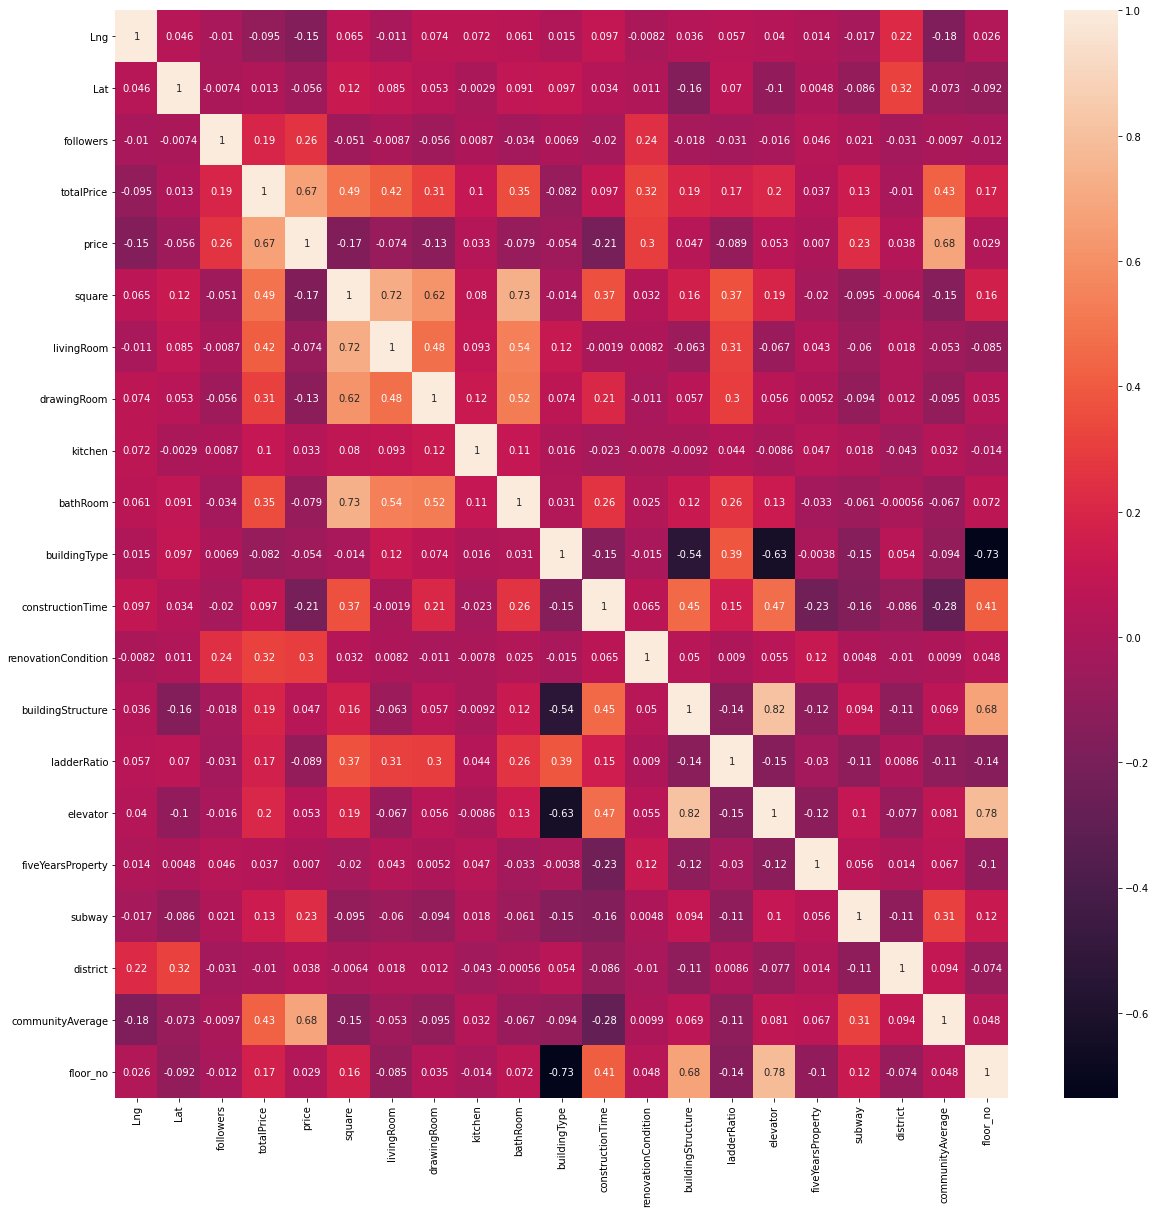

In [13]:
# finding correlation
df.corr()
corrMatrix = df.corr()
plt.subplots(figsize=(20, 20))
sns.heatmap(corrMatrix,annot=True)

Conclusion from correlation matrix.
1. Community average is 0.41 postitvely correlated to totalPrice.
2. Bigger the house, the more expensive it will be (Square positively correlated to totalPrice)
3. Building structure (0-6) have different building materials, thus we have to see what they are in detail.

# Feature Analysis.


**Floor Vs Price**

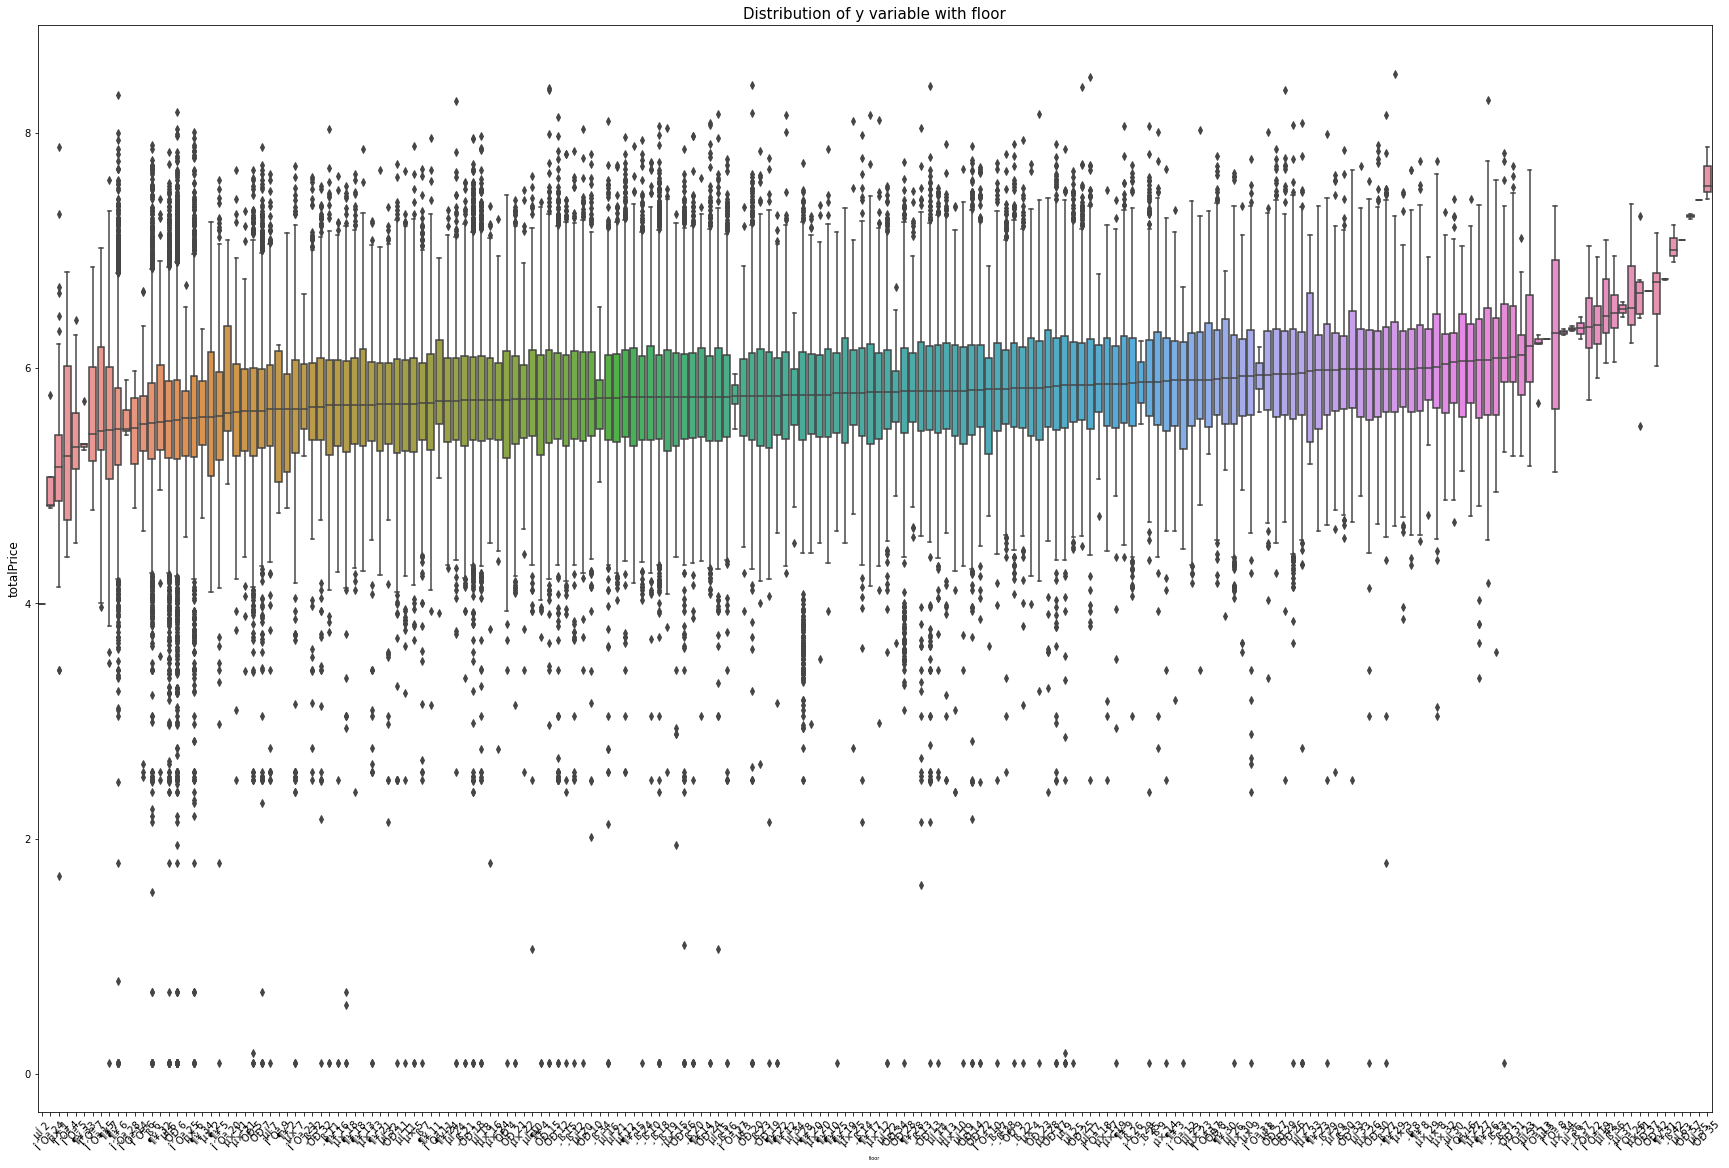

In [ ]:
ranks = df.groupby("floor")["totalPrice"].median().sort_values(ascending=False)[::-1].index

var_name = "floor"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(30,20))
sns.boxplot(x=var_name, y='totalPrice', data=df, order=ranks)
plt.xlabel(var_name, fontsize=5)
plt.ylabel('totalPrice', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

we have to recode the values. There are a total of 6 types of 'floors', with differing values in each of them. While i am not too sure what they individually mean i believe grouping them will give better insights into the types of 'floor' vs prices. 

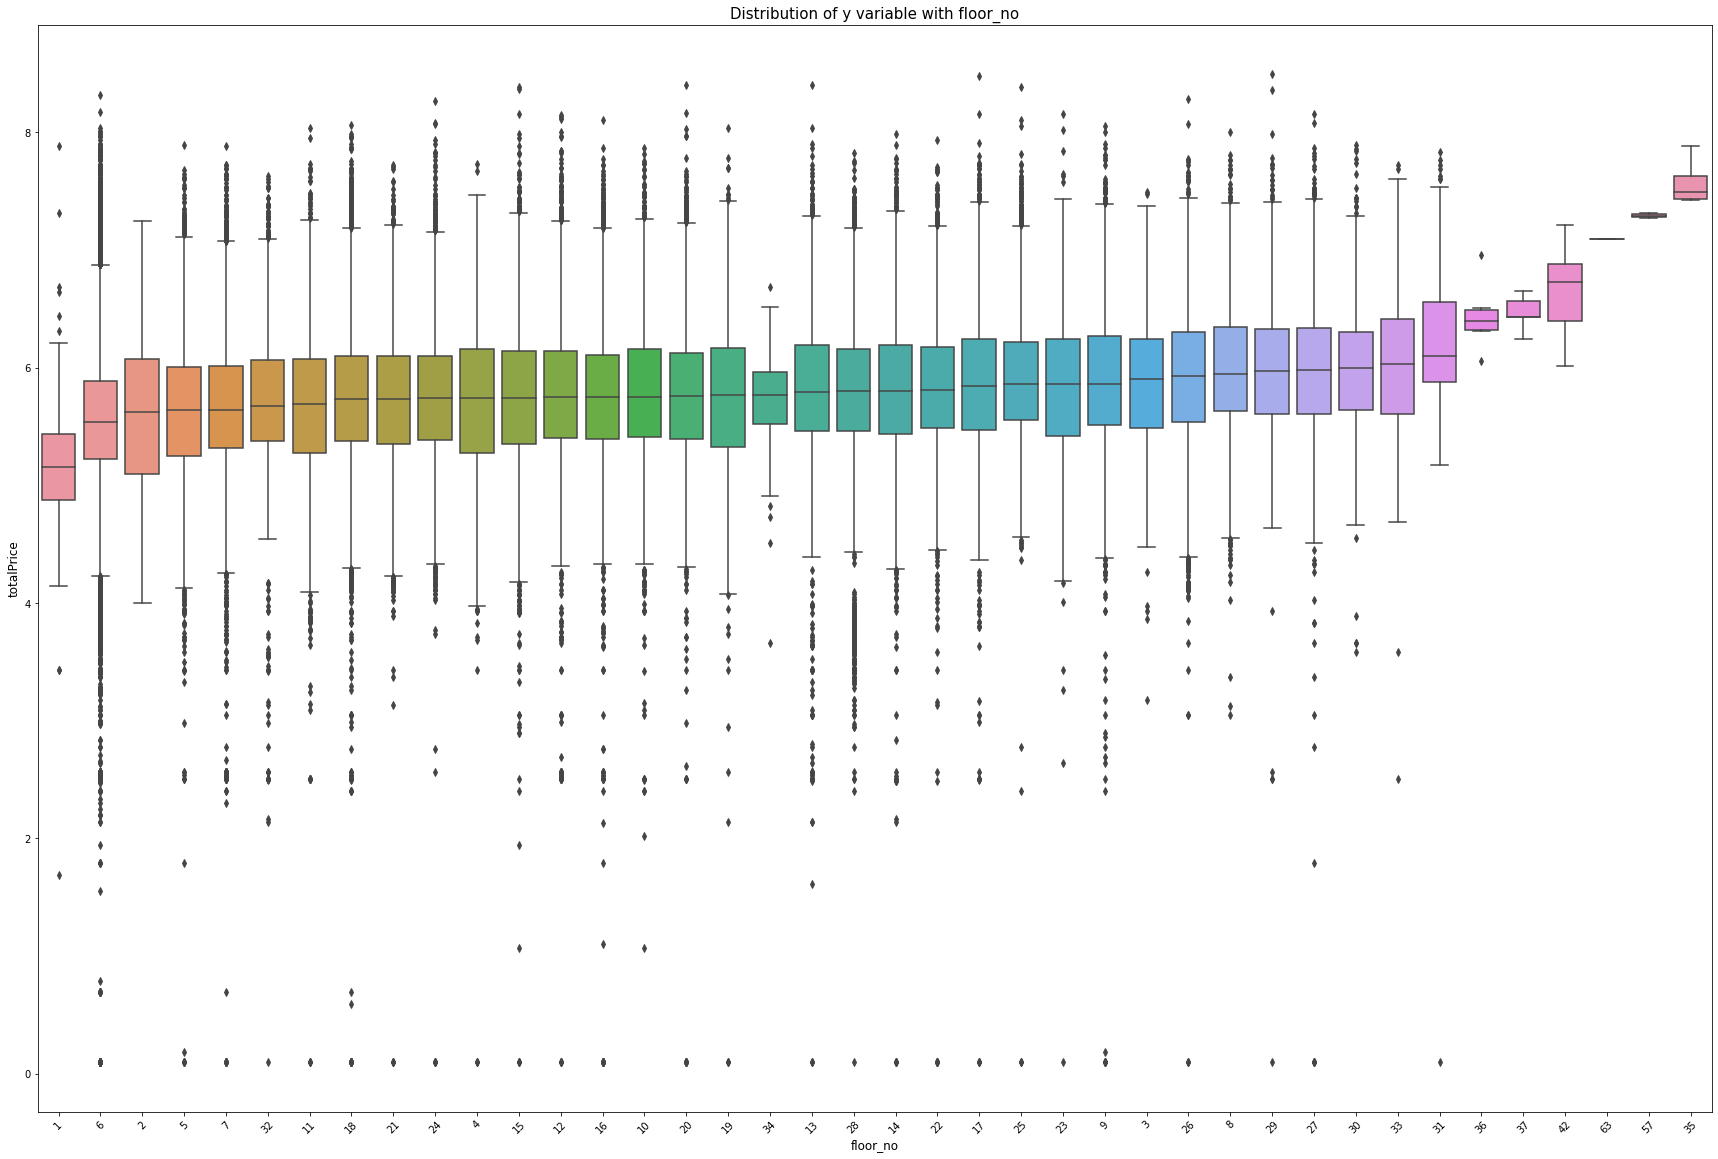

In [ ]:
ranks = df.groupby("floor_no")["totalPrice"].median().sort_values(ascending=False)[::-1].index

var_name = "floor_no"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(30,20))
sns.boxplot(x=var_name, y='totalPrice', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('totalPrice', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

In [ ]:
ranks = df.groupby("floortype")["totalPrice"].median().sort_values(ascending=False)[::-1].index

var_name = "floortype"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(30,20))
sns.boxplot(x=var_name, y='totalPrice', data=df, order=ranks)
plt.xlabel(var_name, fontsize=20)
plt.ylabel('totalPrice', fontsize=20)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

NameError: ignored

Conclusion we will drop floor, and use our two new variables.

In [14]:
df = df.drop(['floor','floortype'],axis='columns')

In [ ]:
df.head()

,Lng,Lat,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,floor_no
0,116.475489,40.019520,106,6.030685,31680,131.00,2,1,1,1,1,2005,3,6,0.217,1,0,1,7,56021.0,26
1,116.453917,39.881534,126,6.356108,43436,132.38,2,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539.0,22
2,116.561978,39.877145,48,6.938284,52021,198.00,3,2,1,3,4,2005,3,6,0.500,1,0,0,7,48160.0,4
3,116.438010,40.076114,138,5.698770,22202,134.00,3,1,1,1,1,2008,1,6,0.273,1,0,0,6,51238.0,21
4,116.428392,39.886229,286,5.973810,48396,81.00,2,1,1,1,4,1960,2,2,0.333,0,1,1,1,62588.0,6


**Building Structure Vs totalPrice**

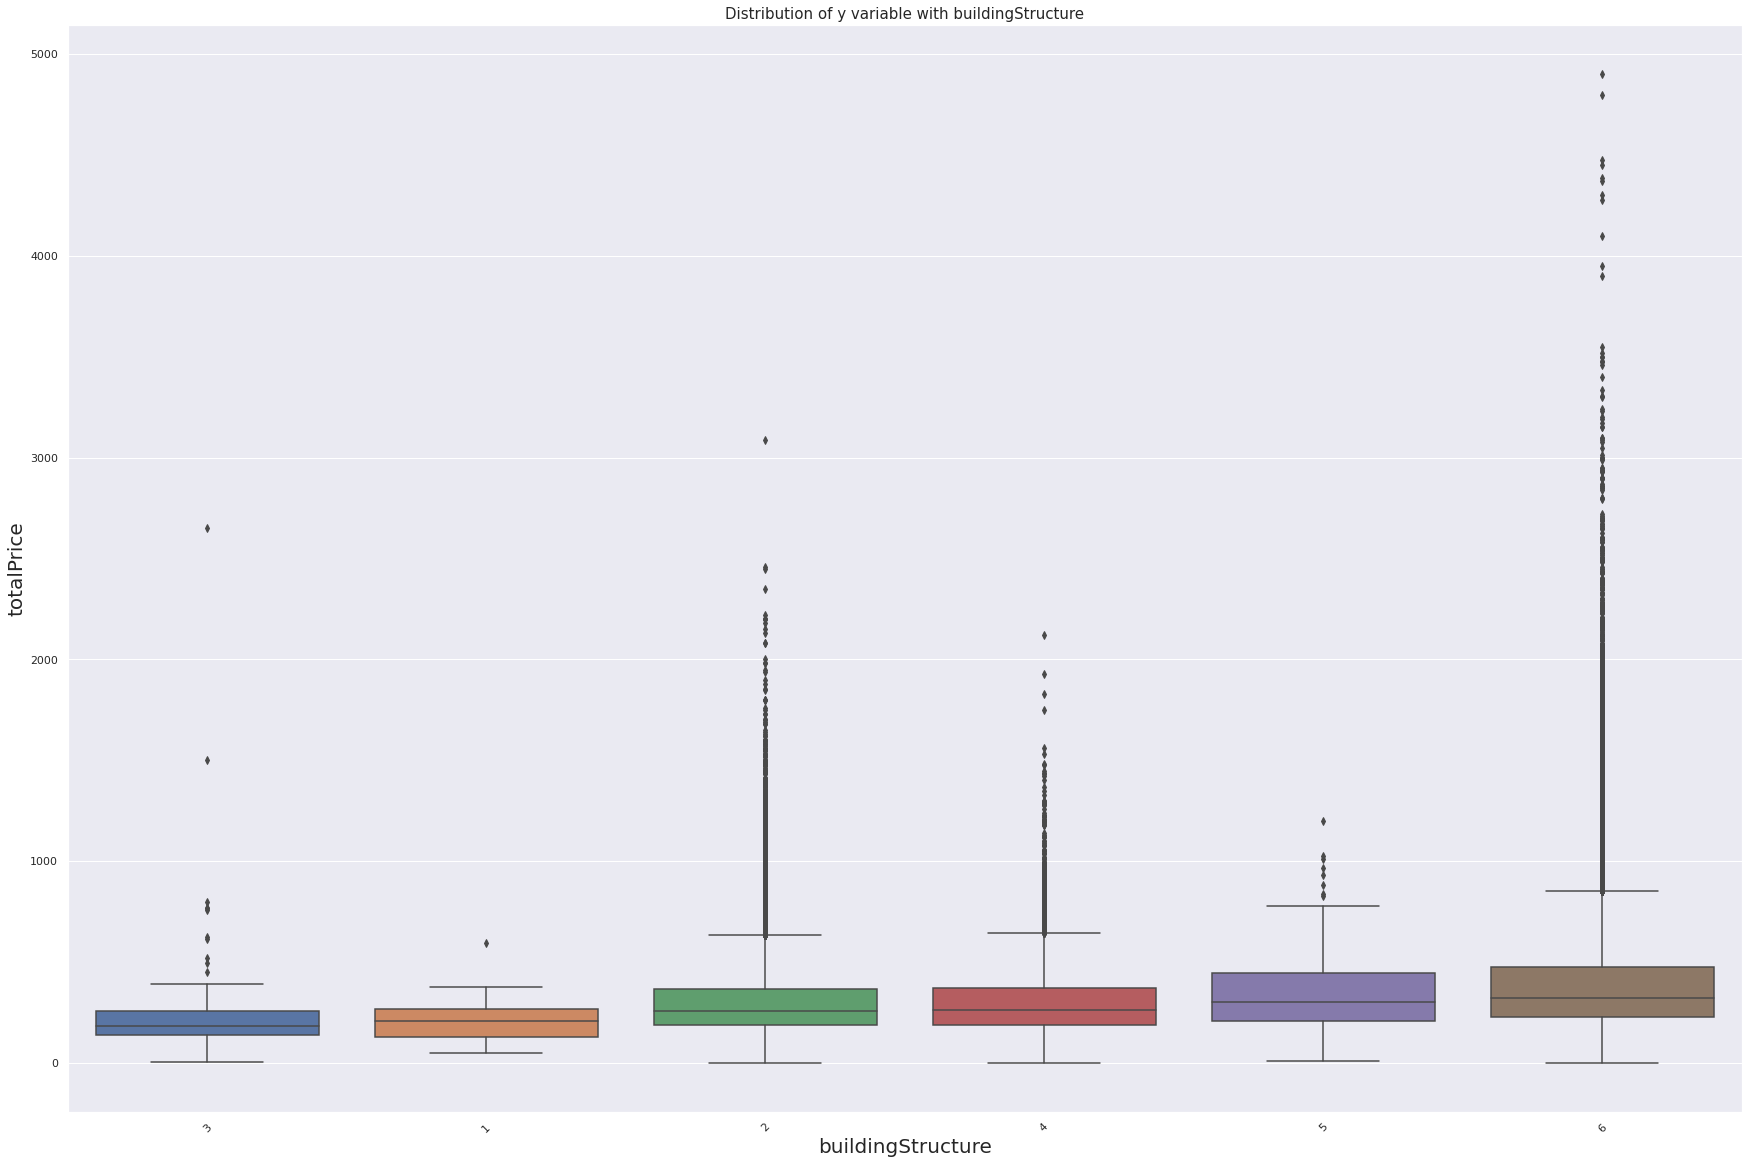

In [ ]:
ranks = df.groupby("buildingStructure")["totalPrice"].median().sort_values(ascending=False)[::-1].index

var_name = "buildingStructure"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(30,20))
sns.boxplot(x=var_name, y='totalPrice', data=df, order=ranks)
plt.xlabel(var_name, fontsize=20)
plt.ylabel('totalPrice', fontsize=20)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

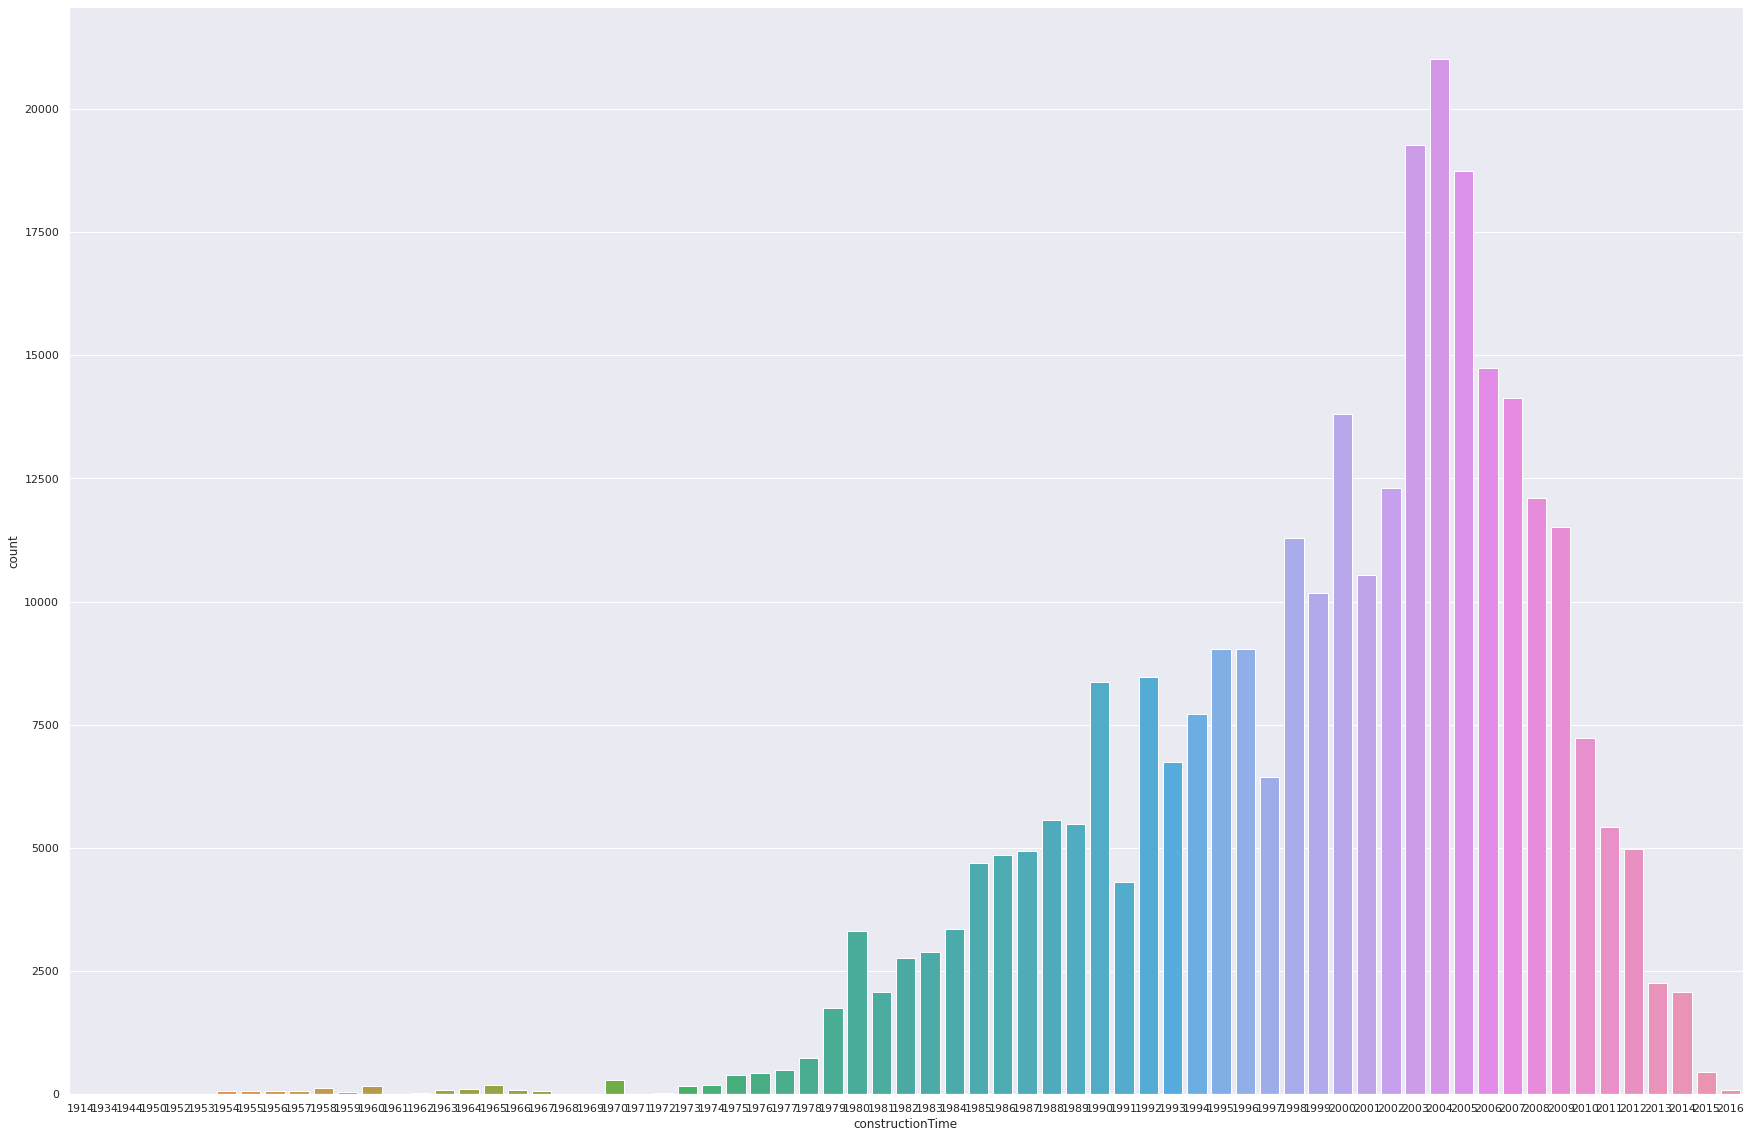

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(30,20))
ax = sns.countplot(x="constructionTime", data=df)

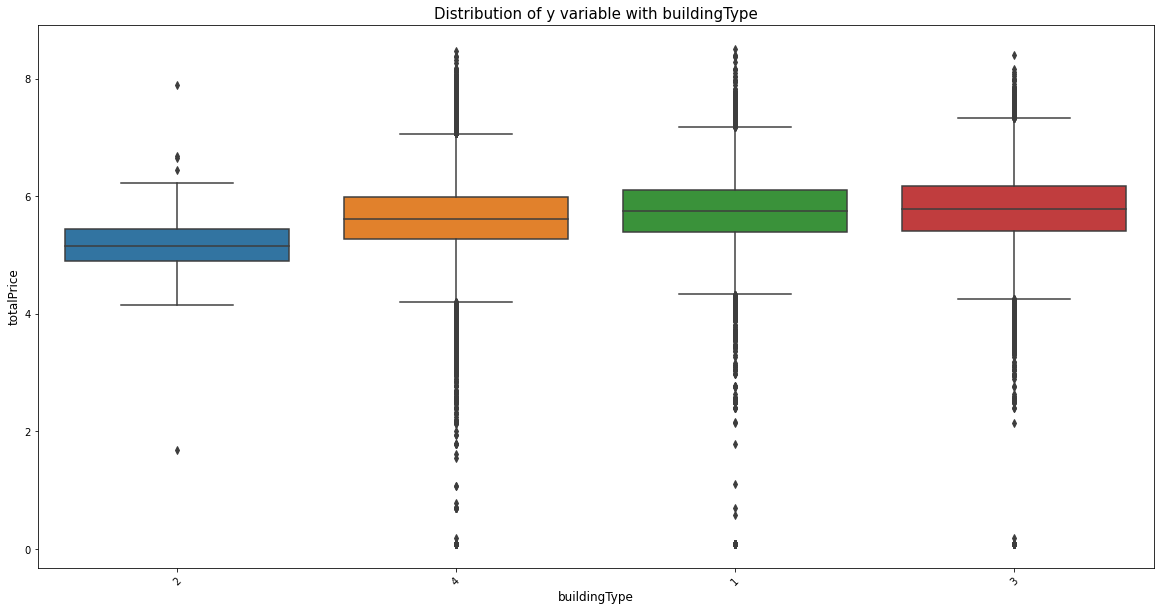

In [ ]:
ranks = df.groupby("buildingType")["totalPrice"].median().sort_values(ascending=False)[::-1].index

var_name = "buildingType"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(20,10))
sns.boxplot(x=var_name, y='totalPrice', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('totalPrice', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

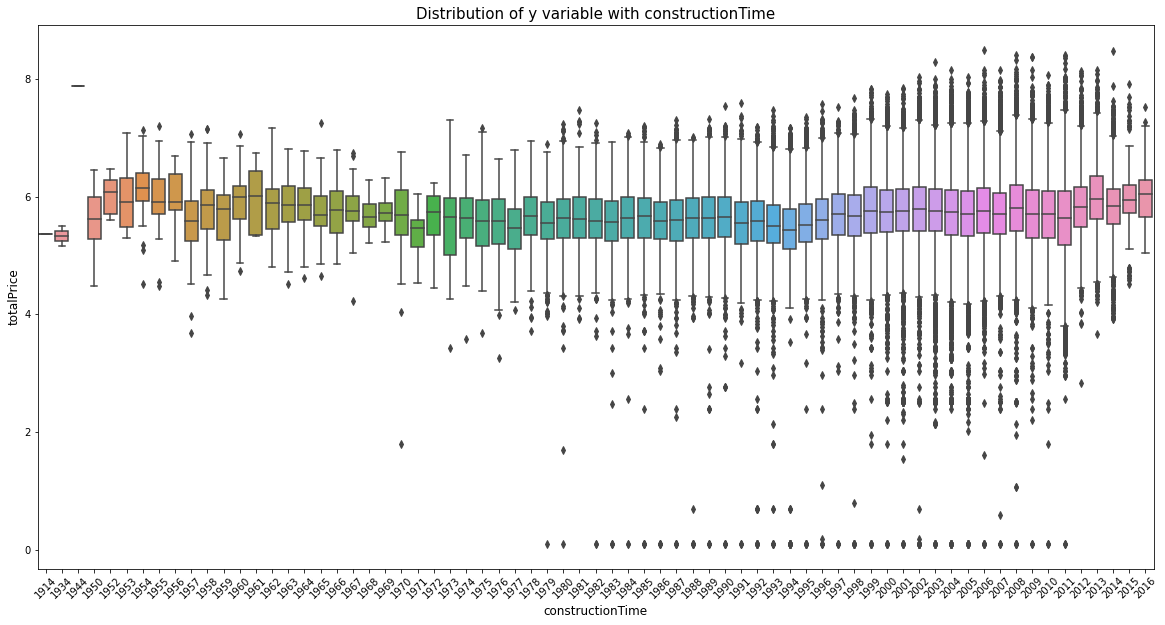

In [ ]:
var_name="constructionTime"
plt.figure(figsize=(20,10))
sns.boxplot(x=var_name, y='totalPrice', data=df,)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('totalPrice', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

It seems like the building type was wrongly coded as there is only suppose to be 1,2,3,4. we will proceed to remove them.

In [ ]:
#df.loc[df['buildingType'] == 0.429]


In [ ]:
# outliers = [243731,92235,92270,92299,92300,92340,92398,92414,92520,92610,92660,92814,92899,113275,208214,224349,92409,92467,92251,92267,92304,92356,92297,92349,92845,141376,220567,220569,220570,220603,244054,245394]

In [ ]:
# df = df.drop(df.index[outliers])

In [ ]:

#var_name = "communityAverage"
#col_order = np.sort(df[var_name].unique()).tolist()
#plt.figure(figsize=(30,20))
#plt.scatter(df["communityAverage"],df["totalPrice"]) # verify that there isnt any left
#plt.xlabel(var_name, fontsize=12)
#plt.ylabel('totalPrice', fontsize=12)
#plt.title("Distribution of y variable with "+var_name, fontsize=15)
#plt.xticks(rotation=45)
#plt.show()


In [ ]:
df = df.dropna() #dropping all null values

In [ ]:
df.head()

,Lng,Lat,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage,floor_no
0,116.475489,40.019520,106,6.030685,31680,131.00,2,1,1,1,1,2005,3,6,0.217,1,0,1,7,56021.0,26
1,116.453917,39.881534,126,6.356108,43436,132.38,2,2,1,2,1,2004,4,6,0.667,1,1,0,7,71539.0,22
2,116.561978,39.877145,48,6.938284,52021,198.00,3,2,1,3,4,2005,3,6,0.500,1,0,0,7,48160.0,4
3,116.438010,40.076114,138,5.698770,22202,134.00,3,1,1,1,1,2008,1,6,0.273,1,0,0,6,51238.0,21
4,116.428392,39.886229,286,5.973810,48396,81.00,2,1,1,1,4,1960,2,2,0.333,0,1,1,1,62588.0,6


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


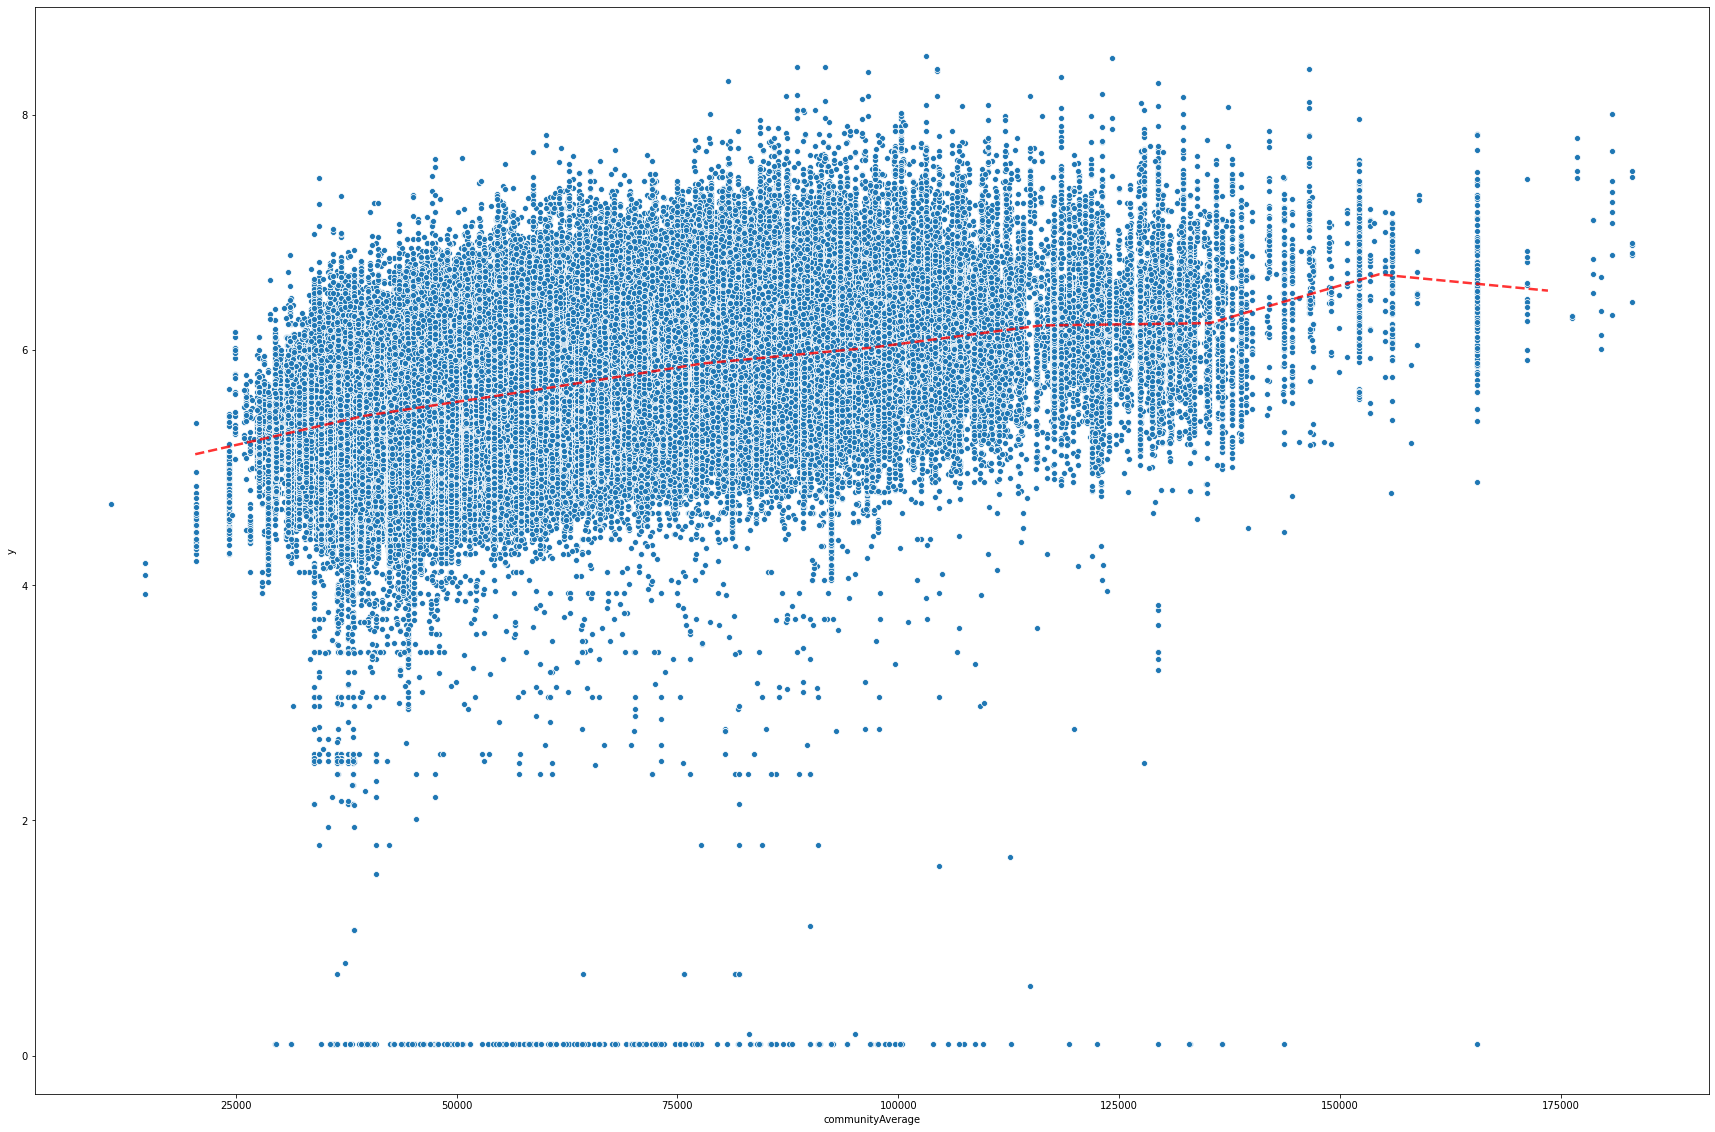

count    297697.000000
mean      63689.042721
std       22167.682746
min       10847.000000
25%       46505.000000
50%       59025.000000
75%       75858.000000
max      183109.000000
Name: communityAverage, dtype: float64


In [ ]:
plt.figure(figsize=(30,20))
plot_df=df.communityAverage
y=df.totalPrice
plot_df=pd.DataFrame(plot_df)
plot_df.insert(1,"y",df.totalPrice)
plot_df.columns=['communityAverage','y'] #rename axis
total_bins=10
bins = np.linspace(plot_df.communityAverage.min(),plot_df.communityAverage.max(),total_bins)
delta=bins[1]-bins[0]
idx=np.digitize(plot_df.communityAverage,bins)
running_median=[np.median(plot_df.y[idx==k]) for k in range(total_bins)]
sns.scatterplot(x='communityAverage', y='y',data=plot_df)
plt.plot(bins-delta/2,running_median,'r--',lw=2.5,alpha=0.8)
plt.axis('tight')
plt.show()
print(plot_df.communityAverage.describe())

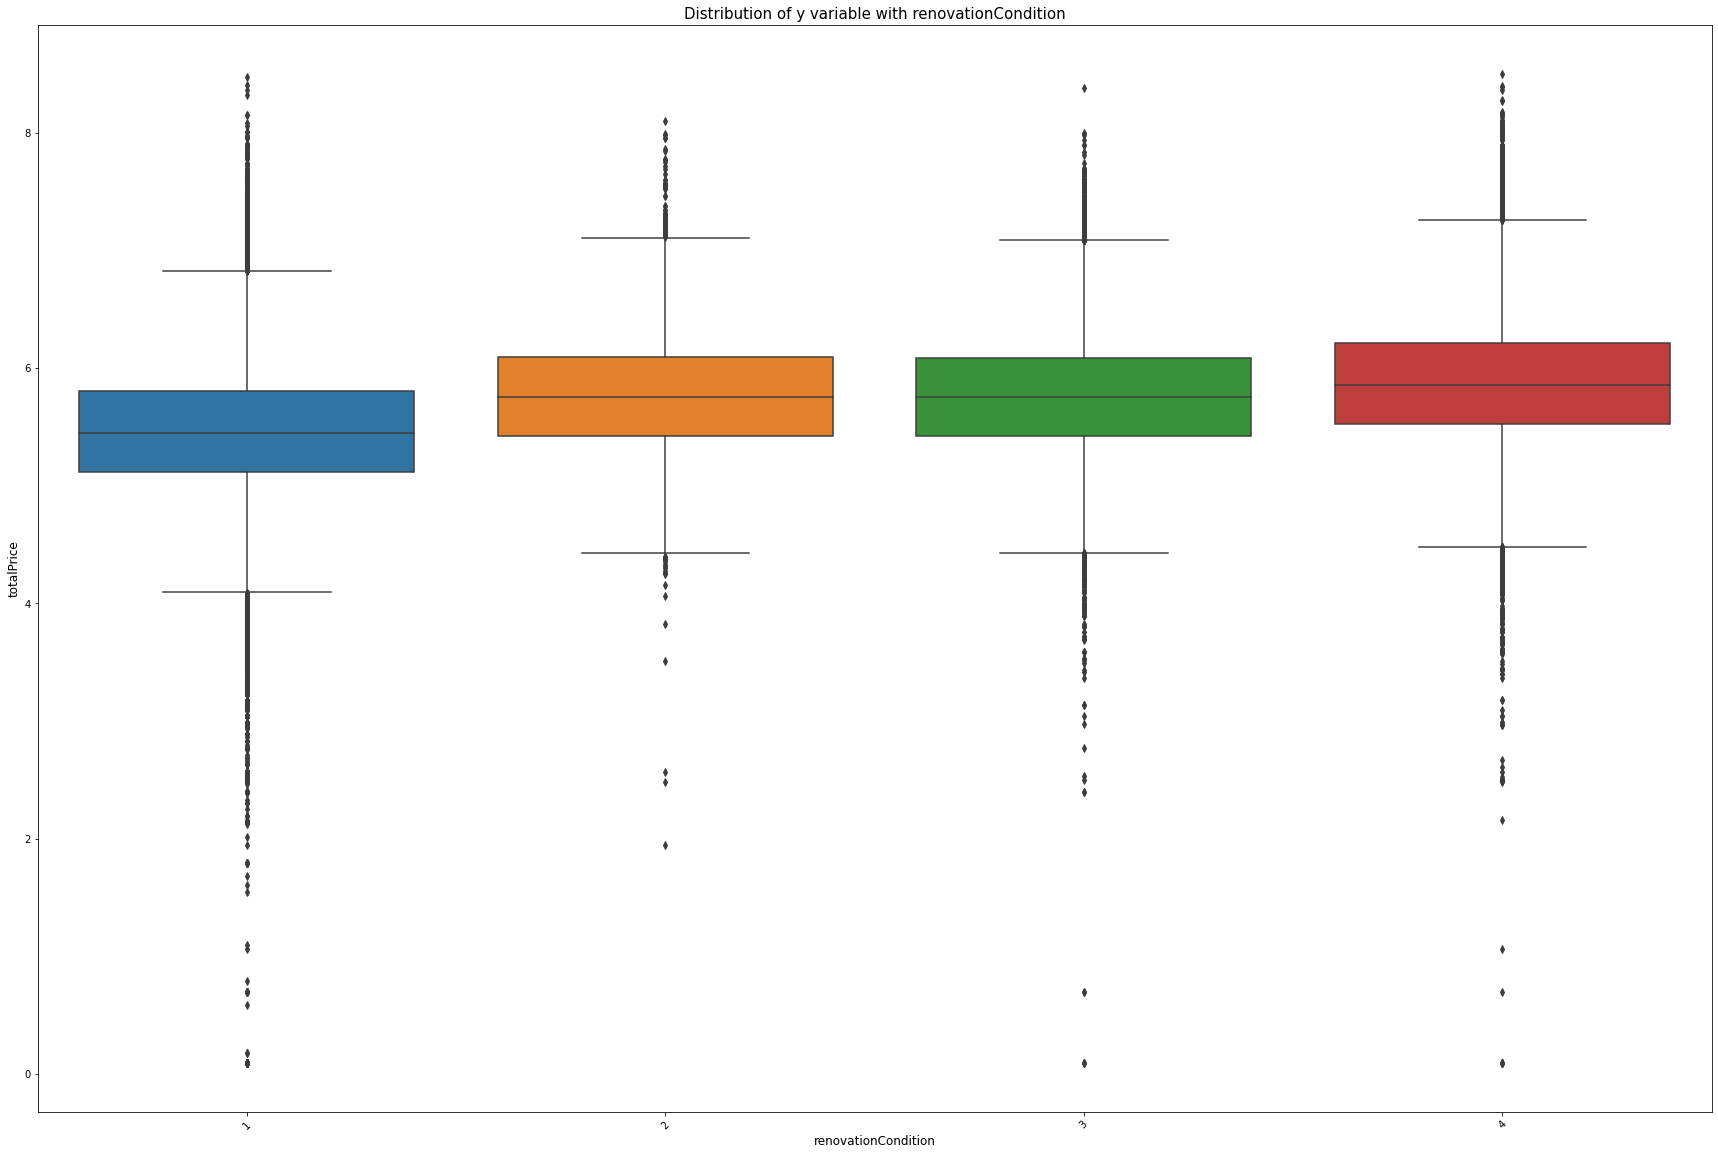

In [ ]:
ranks = df.groupby("renovationCondition")["totalPrice"].median().sort_values(ascending=False)[::-1].index

var_name = "renovationCondition"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(30,20))
sns.boxplot(x=var_name, y='totalPrice', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('totalPrice', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

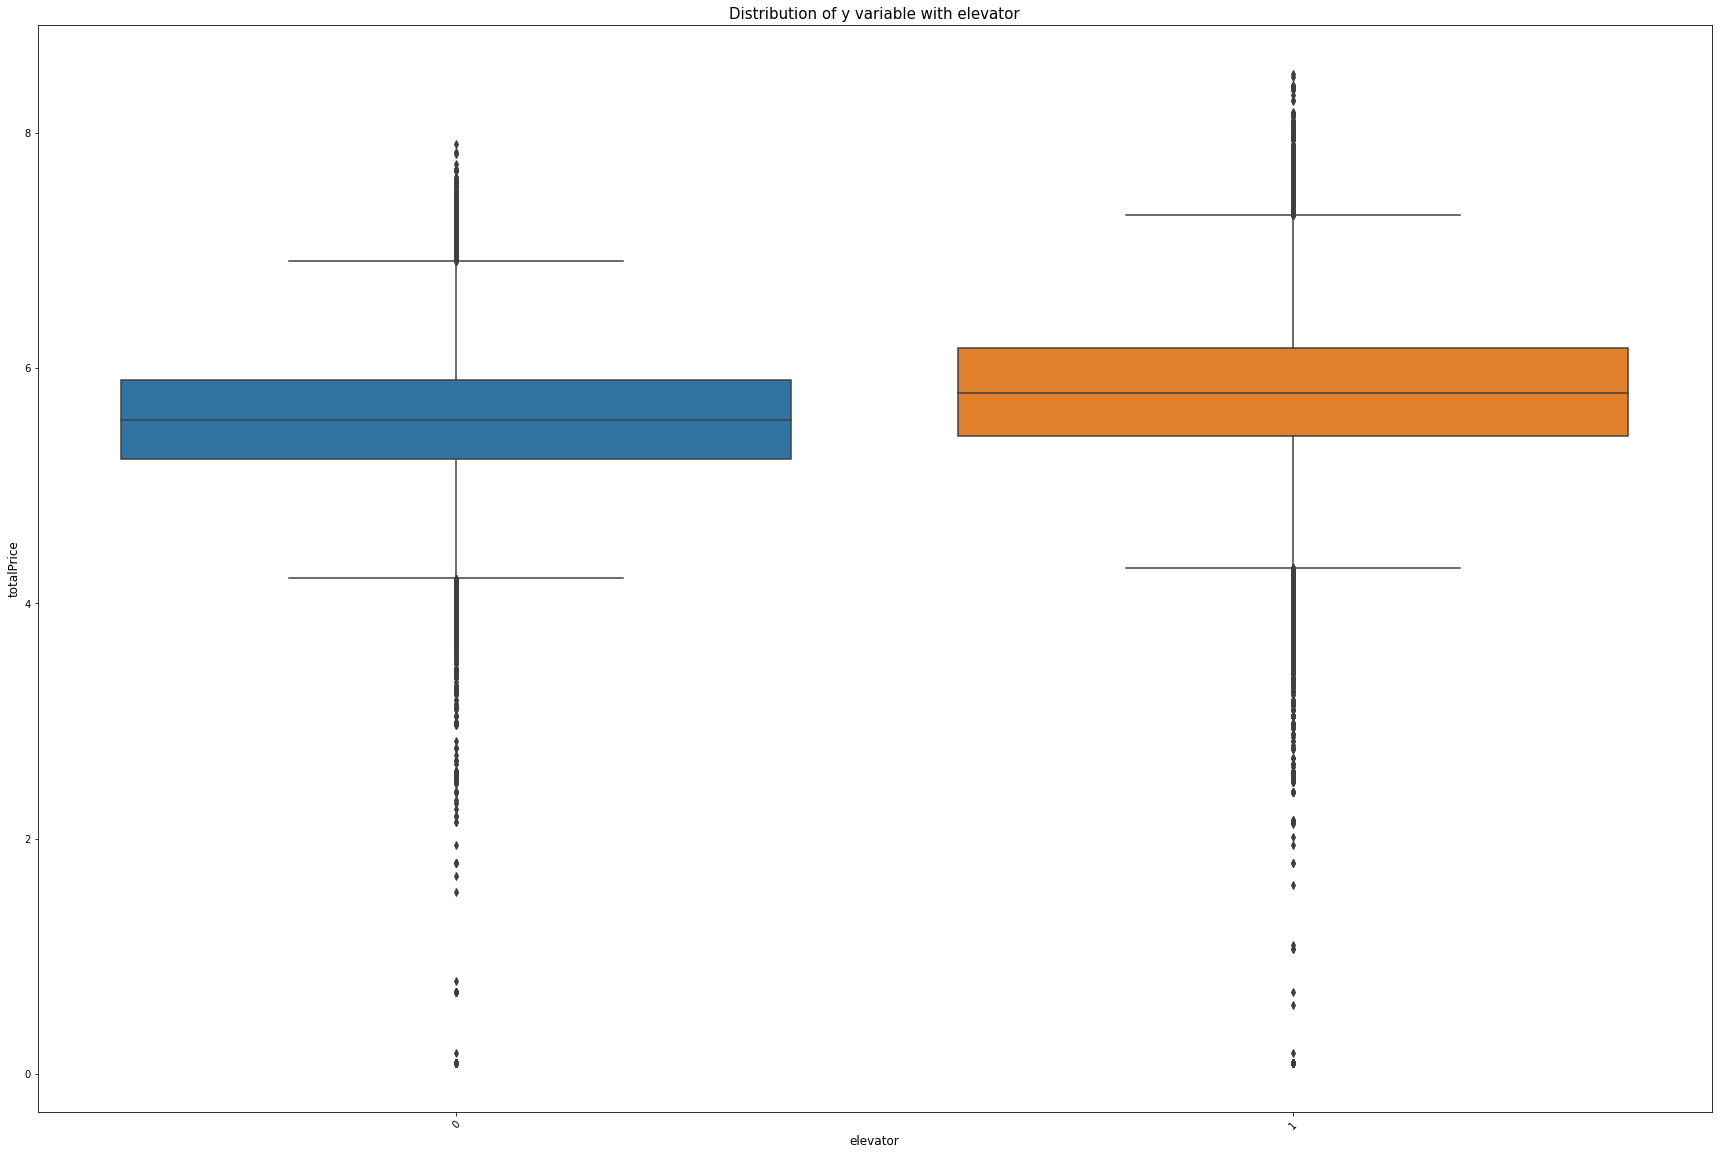

In [ ]:
ranks = df.groupby("elevator")["totalPrice"].median().sort_values(ascending=False)[::-1].index

var_name = "elevator"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(30,20))
sns.boxplot(x=var_name, y='totalPrice', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('totalPrice', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

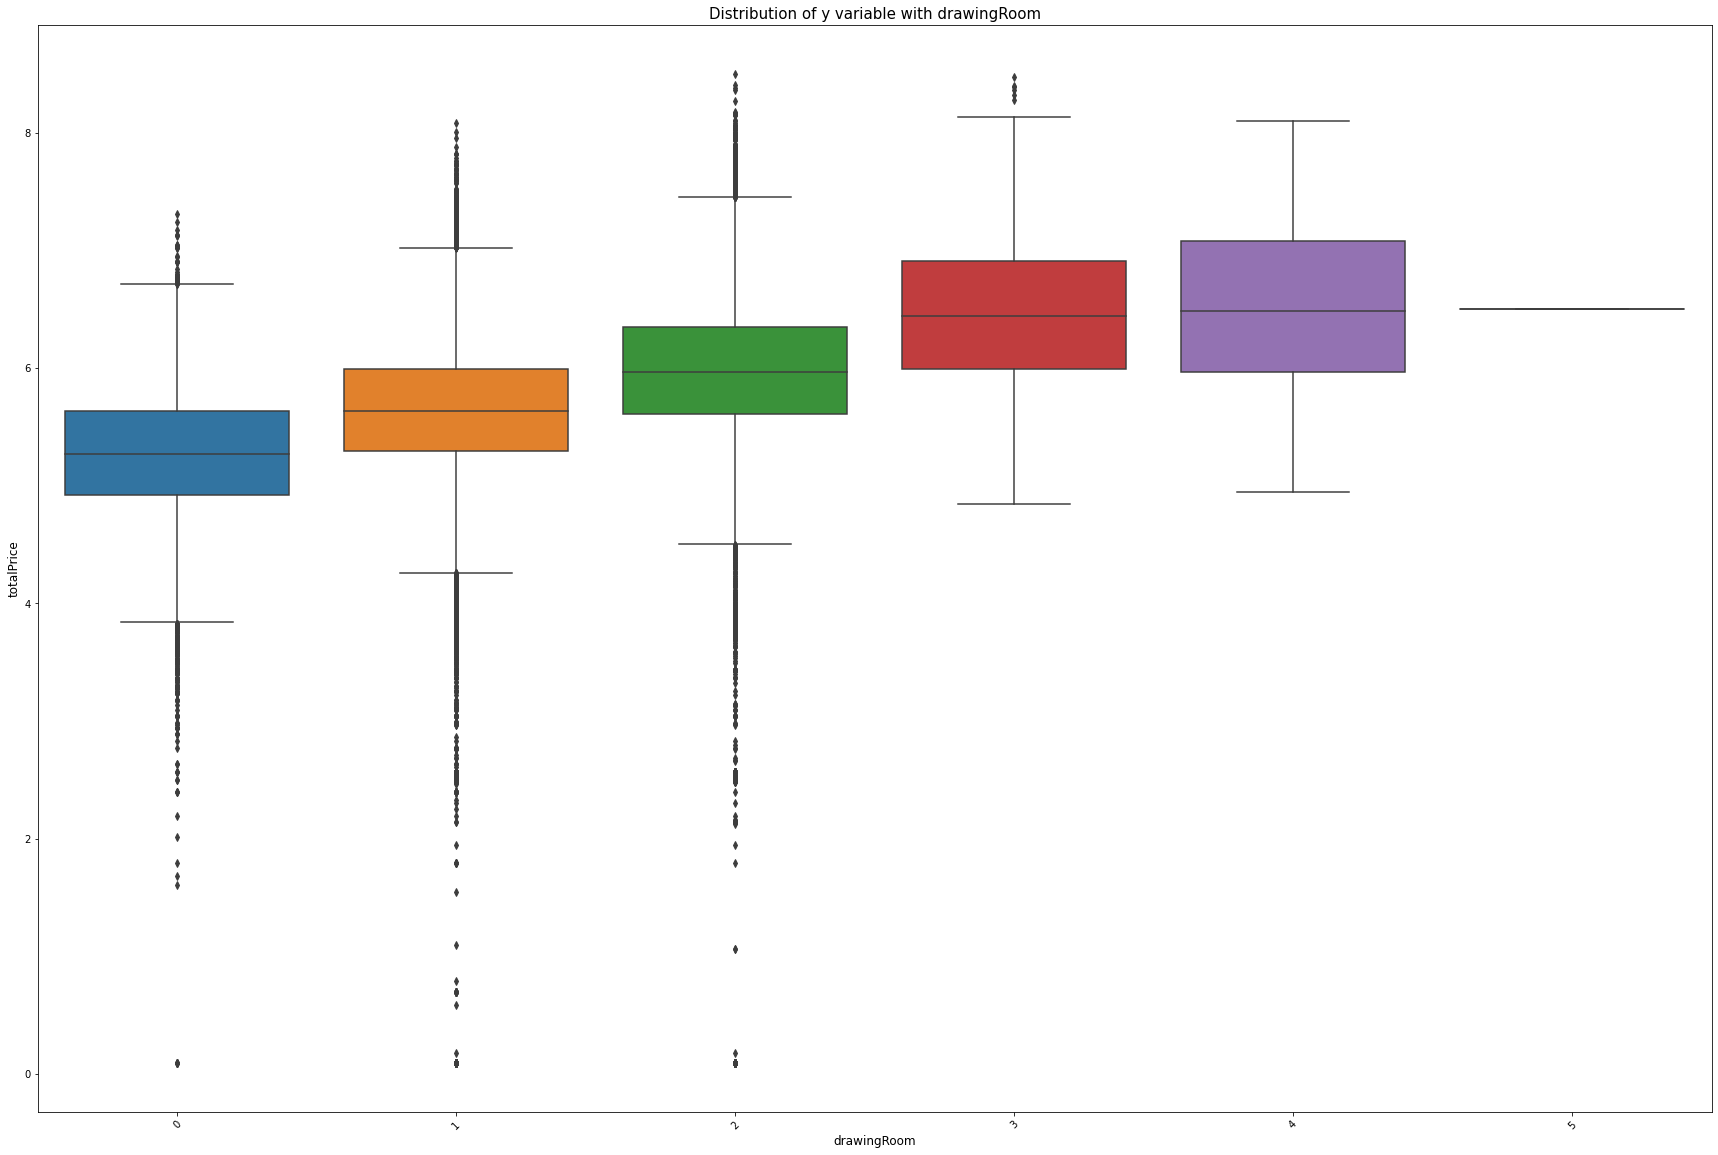

In [9]:
ranks = df.groupby("drawingRoom")["totalPrice"].median().sort_values(ascending=False)[::-1].index

var_name = "drawingRoom"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(30,20))
sns.boxplot(x=var_name, y='totalPrice', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('totalPrice', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

**DISTRICT**

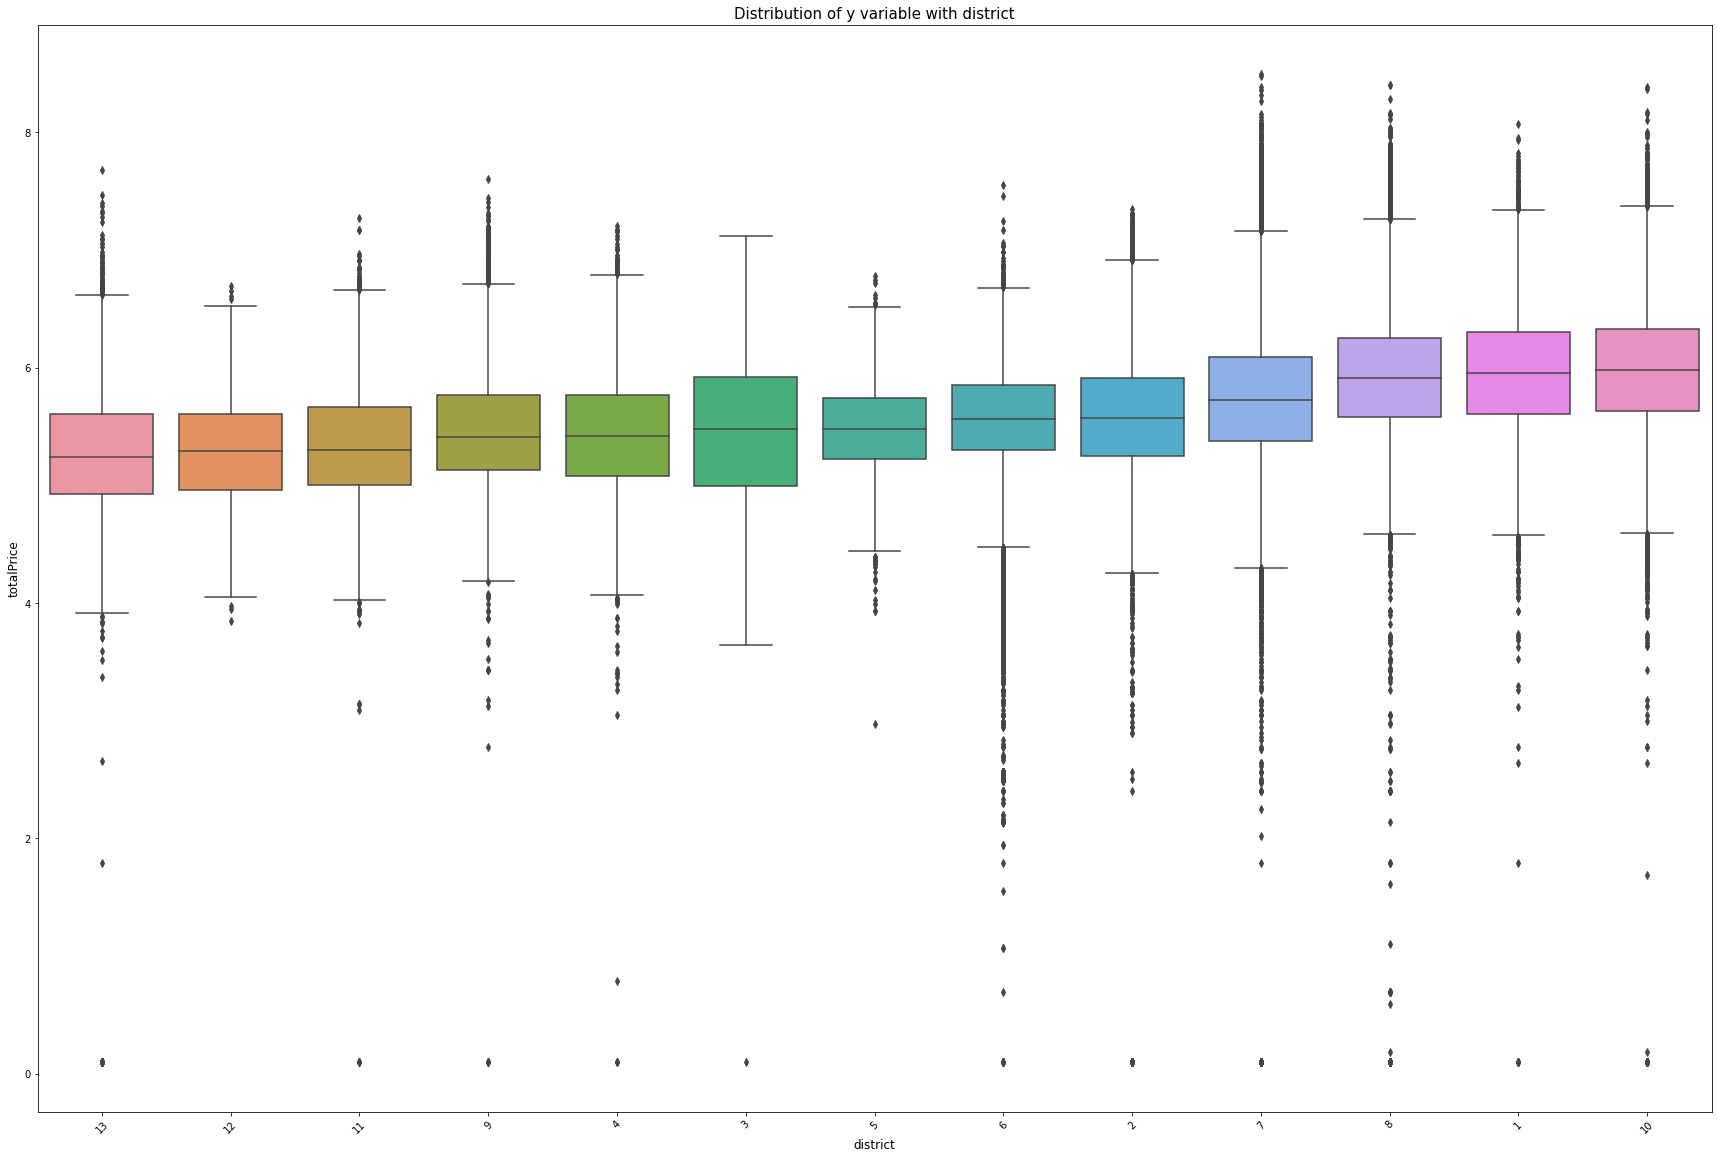

In [ ]:
ranks = df.groupby("district")["totalPrice"].median().sort_values(ascending=False)[::-1].index

var_name = "district"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(30,20))
sns.boxplot(x=var_name, y='totalPrice', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('totalPrice', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# removing outliers
#df.loc[df['ladderRatio'] > 1000]
#turns out to be index 61036,148467
#df = df.drop(df.index[148467])

In [ ]:
# df.loc[df['ladderRatio'] > 1000]

In [ ]:
#df.drop(df.index[148467])

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


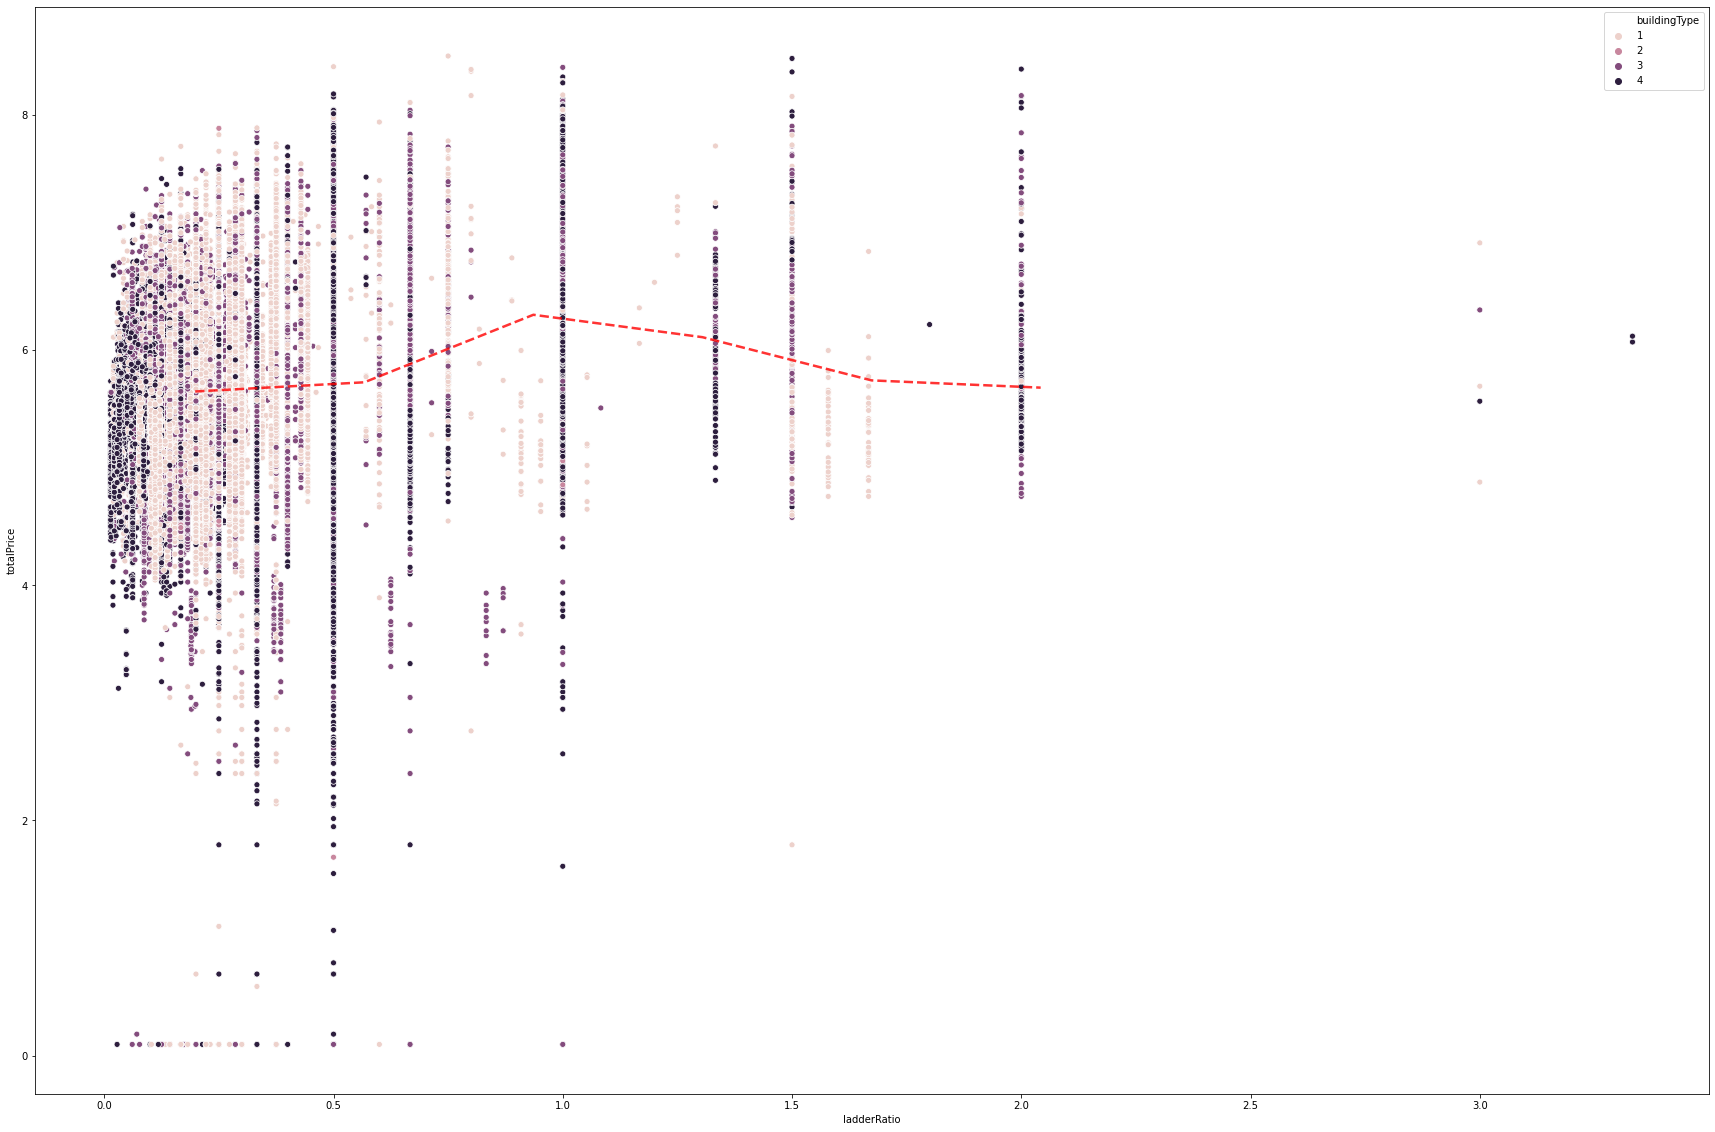

count    297986.000000
mean          0.381853
std           0.175970
min           0.014000
25%           0.250000
50%           0.333000
75%           0.500000
max           3.333000
Name: ladderRatio, dtype: float64


In [12]:
plt.figure(figsize=(30,20))
plot_df=df.ladderRatio
y=df.totalPrice
plot_df=pd.DataFrame(plot_df)
plot_df.insert(1,"y",df.totalPrice)
plot_df.columns=['ladderRatio','y'] #rename axis
total_bins=10
bins = np.linspace(plot_df.ladderRatio.min(),plot_df.ladderRatio.max(),total_bins)
delta=bins[1]-bins[0]
idx=np.digitize(plot_df.ladderRatio,bins)
running_median=[np.median(plot_df.y[idx==k]) for k in range(total_bins)]
sns.scatterplot(x='ladderRatio', y='totalPrice',data=df, hue = "buildingType")
plt.plot(bins-delta/2,running_median,'r--',lw=2.5,alpha=0.8)
plt.axis('tight')
plt.show()
print(plot_df.ladderRatio.describe())

there seems to be some abnormalies in the ladder ratio, we seem to have ladder readings that are abnormalies. 

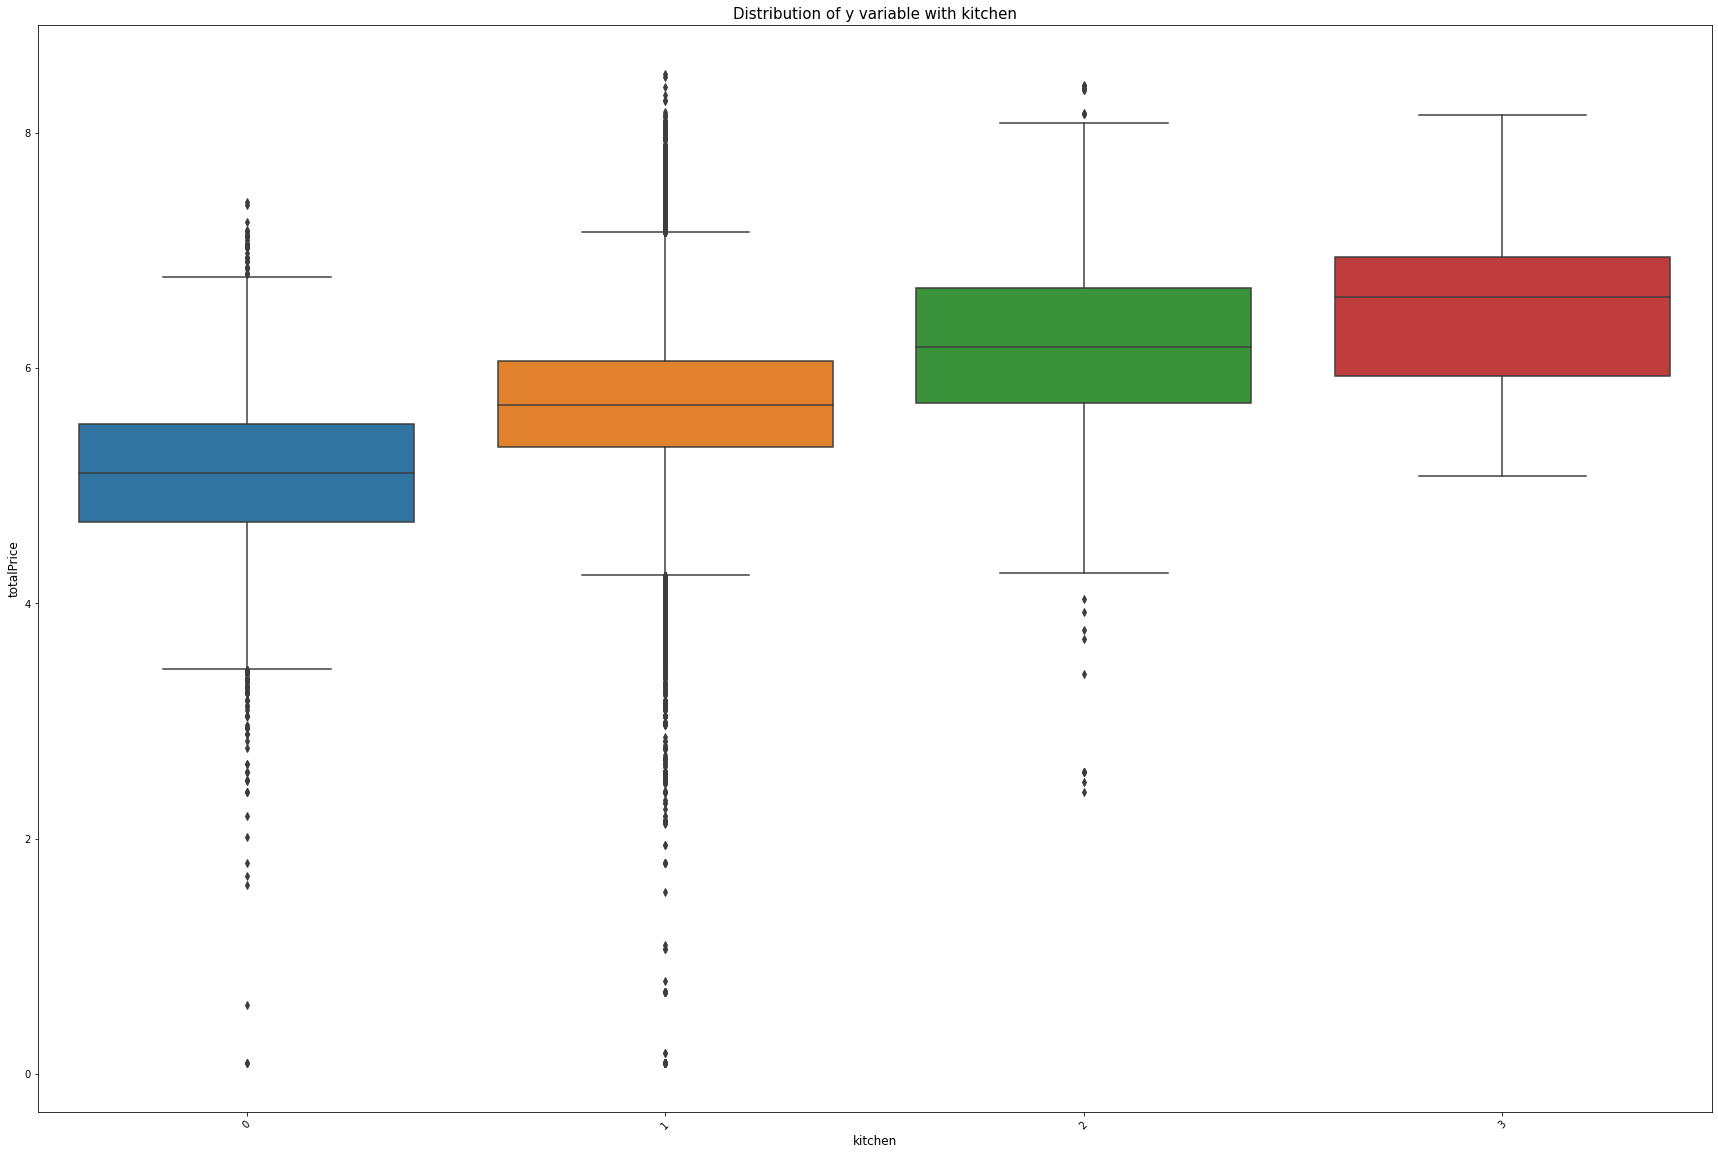

In [ ]:
ranks = df.groupby("kitchen")["totalPrice"].median().sort_values(ascending=False)[::-1].index

var_name = "kitchen"
col_order = np.sort(df[var_name].unique()).tolist()
plt.figure(figsize=(30,20))
sns.boxplot(x=var_name, y='totalPrice', data=df, order=ranks)
plt.xlabel(var_name, fontsize=12)
plt.ylabel('totalPrice', fontsize=12)
plt.title("Distribution of y variable with "+var_name, fontsize=15)
plt.xticks(rotation=45)
plt.show()

there is an obvious correlation that the more kitchen you have, the hire the share price will be

Detailed correlation matrix measures only top correlated features

In [ ]:
threshold = 0.4

corr_list = []

#first 10 features
for i in range(0,17): 
    for j in range(i+1,17): 
        if (corrMatrix.iloc[i,j] >= threshold and corrMatrix.iloc[i,j] < 1) or (corrMatrix.iloc[i,j] < 0 and corrMatrix.iloc[i,j] <= -threshold):
            corr_list.append([corrMatrix.iloc[i,j],i,j]) 

       


for v,i,j in corr_list:
    print ("%s and %s = %.2f" % (df.columns[i],df.columns[j],v))

totalPrice and price = 0.67
totalPrice and square = 0.49
totalPrice and livingRoom = 0.42
square and livingRoom = 0.72
square and drawingRoom = 0.62
square and bathRoom = 0.73
livingRoom and drawingRoom = 0.48
livingRoom and bathRoom = 0.54
drawingRoom and bathRoom = 0.52
buildingType and buildingStructure = -0.54
buildingType and elevator = -0.63
constructionTime and buildingStructure = 0.45
constructionTime and elevator = 0.47
buildingStructure and elevator = 0.82


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


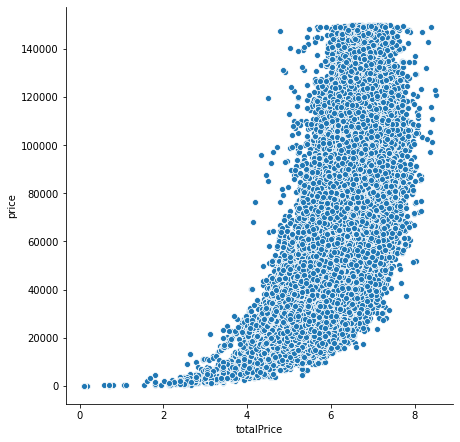

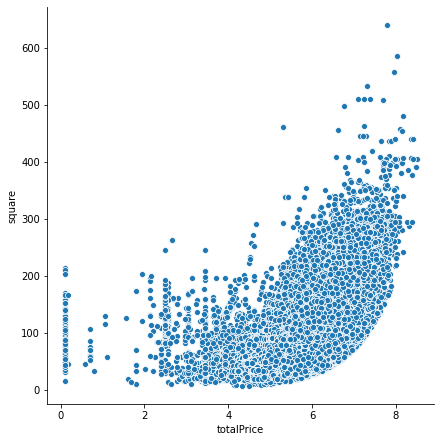

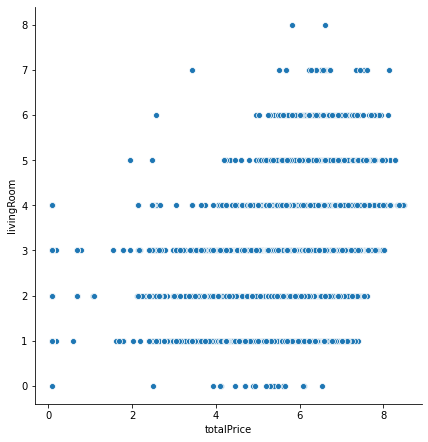

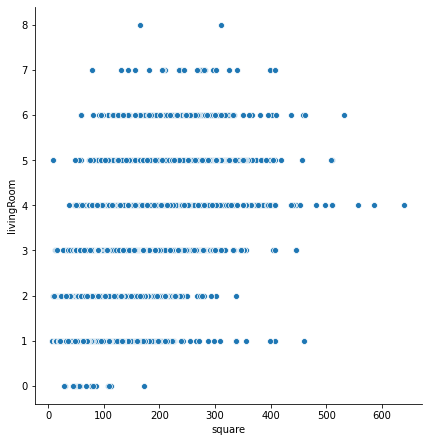

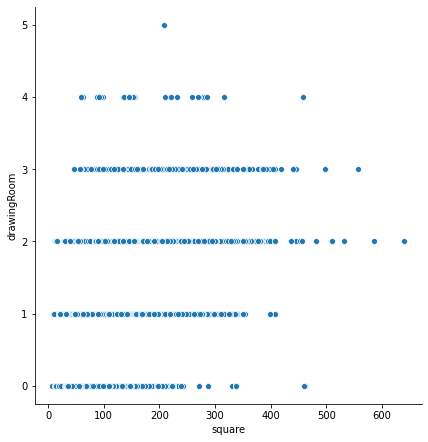

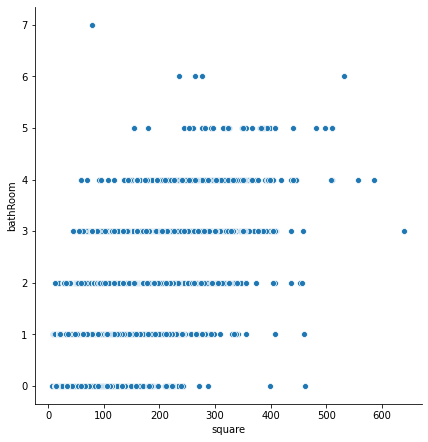

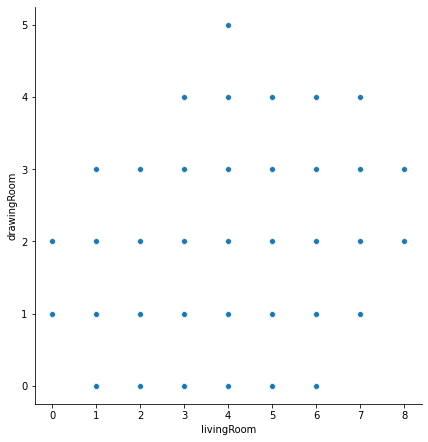

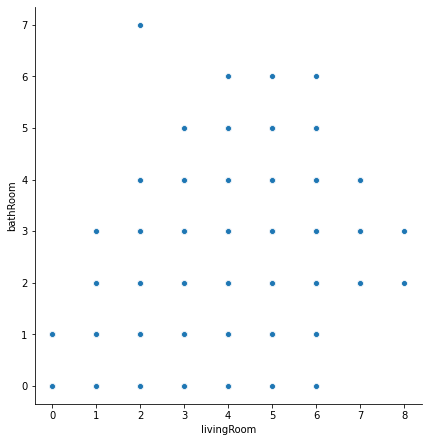

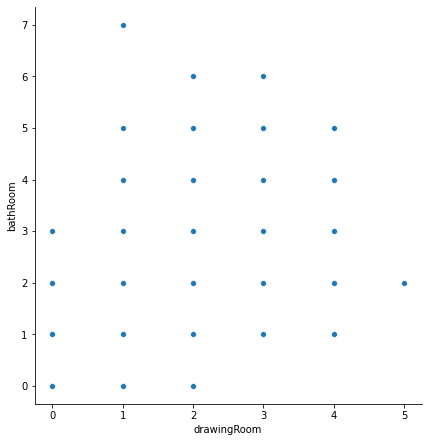

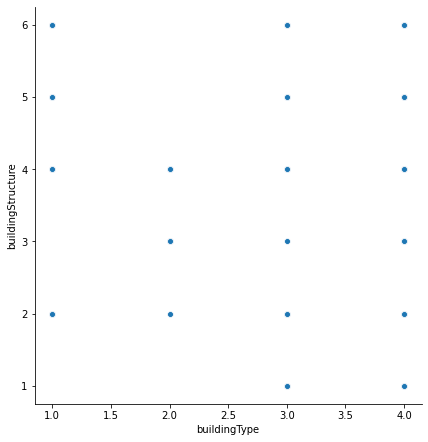

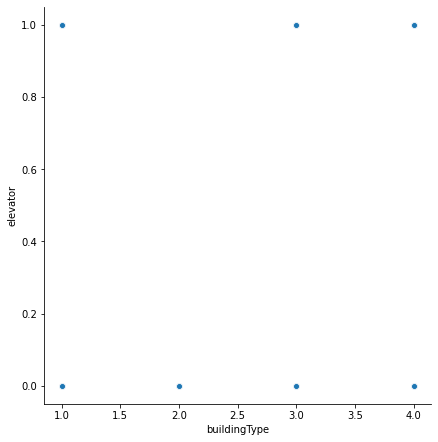

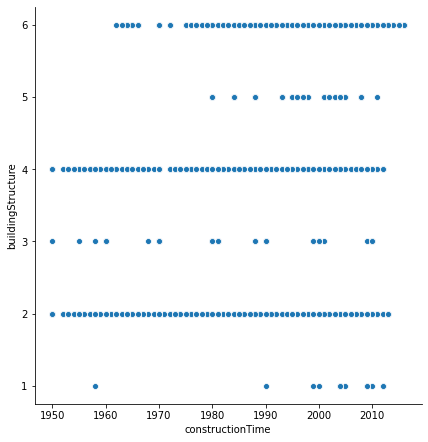

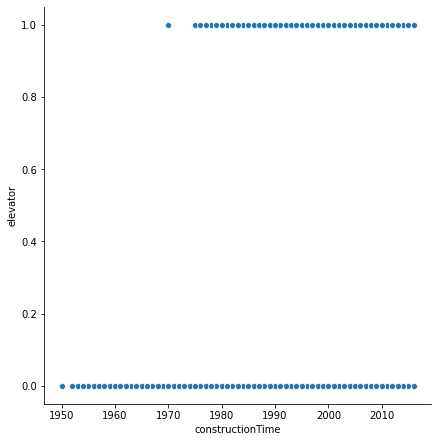

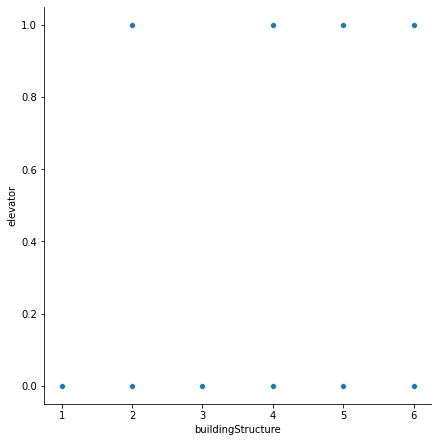

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


for v,i,j in corr_list:
    sns.pairplot(df, size=6, x_vars=df.columns[i],y_vars=df.columns[j] )
    plt.show()

Some of the graphs are meaningless goes to show that there is only so much correlation matrixes can do

In [ ]:
df.shape

(297697, 21)

In [ ]:
deselectlist =[ 'tradeTime', 'followers' , 'price','square','livingRoom','drawingRoom','kitchen','bathRoom','floor','buildingType','constructionTime','renovationCondition','buildingStructure','ladderRatio','elevator','fiveYearsProperty','subway','district','communityAverage']
selectlist =[x for x in df.columns if x not in deselectlist]
datatowrite = df[selectlist]

datatowrite.to_csv('new.csv')

In [ ]:
datatowrite

,Lng,Lat,totalPrice,floor_no
0,116.475489,40.019520,6.030685,26
1,116.453917,39.881534,6.356108,22
2,116.561978,39.877145,6.938284,4
3,116.438010,40.076114,5.698770,21
4,116.428392,39.886229,5.973810,6
...,...,...,...,...
297981,116.546899,39.755236,5.876334,9
297982,116.546899,39.755236,5.860786,5
297983,116.497474,39.810115,4.698661,24
297984,116.497256,39.804081,5.886104,7


# Geoplot of visualisaton

see python notebook

## Neural Network

We will now start modelling. We have yet to standardize the model

In [15]:
# split into input (X) and output (Y) variables
y_list =['totalPrice']
x_list =[x for x in df.columns if x not in y_list]
X = df[x_list]
Y = df[y_list]

In [16]:
print(X.head())
print(Y.head())

          Lng        Lat  followers  ...  district  communityAverage  floor_no
0  116.475489  40.019520        106  ...         7             56021        26
1  116.453917  39.881534        126  ...         7             71539        22
2  116.561978  39.877145         48  ...         7             48160         4
3  116.438010  40.076114        138  ...         6             51238        21
4  116.428392  39.886229        286  ...         1             62588         6

[5 rows x 20 columns]
   totalPrice
0    6.030685
1    6.356108
2    6.938284
3    5.698770
4    5.973810


In [17]:

column_list=['Lng','Lat','followers','price','ladderRatio','communityAverage','floor_no']
category_list=['livingRoom','drawingRoom','kitchen','bathRoom','buildingType','renovationCondition','buildingStructure','elevator','fiveYearsProperty','subway','district']

## Modelling

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [19]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_final= scaler.fit_transform(X)
Y_final= scaler.fit_transform(Y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_final, Y_final)

In [21]:
print(X_train.shape)
print(y_train)

(223272, 20)
[[0.6192667 ]
 [0.63354954]
 [0.68688852]
 ...
 [0.68688852]
 [0.57510236]
 [0.63997078]]


In [22]:
# Define model
model = Sequential()
model.add(Dense(100, input_dim=20, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1))
model.summary() #Print model Summary


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error","accuracy"])

In [24]:
history = model.fit(X_train, y_train, epochs=50,validation_split=0.2,batch_size=20, verbose=1)

Epoch 1/50
8931/8931 [==============================] - 15s 2ms/step - loss: 9.6517e-04 - mean_squared_error: 9.6517e-04 - accuracy: 4.6468e-04 - val_loss: 1.2234e-04 - val_mean_squared_error: 1.2234e-04 - val_accuracy: 8.0618e-04
Epoch 2/50
8931/8931 [==============================] - 15s 2ms/step - loss: 1.3061e-04 - mean_squared_error: 1.3061e-04 - accuracy: 6.6063e-04 - val_loss: 2.8728e-04 - val_mean_squared_error: 2.8728e-04 - val_accuracy: 8.0618e-04
Epoch 3/50
8931/8931 [==============================] - 15s 2ms/step - loss: 7.0882e-05 - mean_squared_error: 7.0882e-05 - accuracy: 6.6063e-04 - val_loss: 2.8716e-05 - val_mean_squared_error: 2.8716e-05 - val_accuracy: 8.0618e-04
Epoch 4/50
8931/8931 [==============================] - 15s 2ms/step - loss: 5.1309e-05 - mean_squared_error: 5.1309e-05 - accuracy: 6.6063e-04 - val_loss: 2.4260e-05 - val_mean_squared_error: 2.4260e-05 - val_accuracy: 8.0618e-04
Epoch 5/50
8931/8931 [==============================] - 16s 2ms/step - loss:

dict_keys(['loss', 'mean_squared_error', 'accuracy', 'val_loss', 'val_mean_squared_error', 'val_accuracy'])


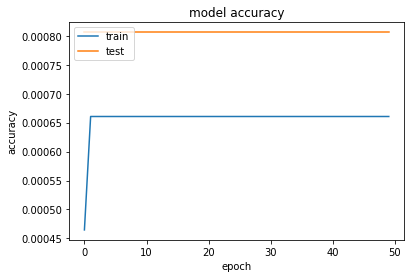

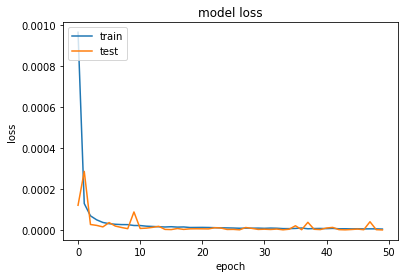

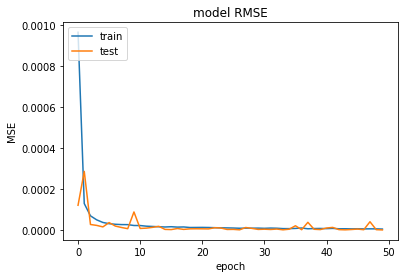

In [25]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#summarize history for RMSE
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Validation

In [26]:
y_test_nn = model.predict(X_test)


In [27]:
y_test_nn_inv=scaler.inverse_transform(y_test_nn)
y_test_inv=scaler.inverse_transform(y_test)

In [28]:
y_test_nn_inv

array([[6.550891 ],
       [5.3412056],
       [5.5779586],
       ...,
       [5.2138615],
       [5.7389894],
       [5.381106 ]], dtype=float32)

In [29]:
y_test_nn_final=np.expm1(y_test_nn_inv)
y_test_inv=np.expm1(y_test_inv)

In [33]:
y_test_nn_final.shape

(74425, 1)

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
#(y_test_inv,y_test_nn_final)
print(sqrt(mean_squared_error(y_test_inv,y_test_nn_final)))
print(mean_absolute_error(y_test_inv,y_test_nn_final))


7.234757351567492
2.757993556616876


In [34]:
y_test_inv.shape

(74425, 1)

In [37]:
X_test_inv=scaler.inverse_transform(X_test)

In [39]:
X_test_inv

array([[6.57685176, 6.03817226, 0.17616821, ..., 8.49719454, 2.06460395,
        0.63736724],
       [2.99815667, 3.41055587, 0.11001164, ..., 0.79546721, 2.37919541,
        0.7728815 ],
       [5.39334402, 3.50149948, 0.09531018, ..., 4.29625236, 2.41962895,
        0.7728815 ],
       ...,
       [4.5804239 , 4.70056404, 0.10266091, ..., 4.29625236, 2.98530829,
        0.90839576],
       [3.48440414, 6.10000533, 0.17616821, ..., 3.59609533, 2.01495215,
        2.67008119],
       [5.12711857, 4.80948691, 0.09531018, ..., 4.29625236, 3.99526881,
        2.39905267]])